# Workspace

In [1]:
# magics
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False


In [2]:
# pandas stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from difflib import get_close_matches
from shapely.geometry import Point

# get timestamp in utc format
from datetime import datetime
timestamp = datetime.utcnow().strftime('%Y%m%dT%H%MZ')
print(f'Timestamp for saving outputs: {timestamp}')

from criteriaetl.utils.display_func import (cdisplay, rdisplay, 
    percentage_count_plot)
from criteriaetl.transformers.fusion_base import MergeTransformer
from criteriaetl.transformers.columns_base import (NameTransformer, 
    ReplaceTransformer, SelectTransformer, AssignTransformer)
from projectetl.utils.config import data_dir
from projectetl.utils.dataload import load_s3_data_do
from projectetl.utils.save import protected_save
from projectetl.utils.process import name_normalizer
from projectetl.utils.dataload import get_path_from_pattern
from projectetl.utils.display import plot_interactive_geojson

import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(3000)

def non_repeated_columns(df1:pd.DataFrame, df2:pd.DataFrame, keep_columns:list = [], exclude_columns:list = [], include_geometry:bool =False):
    '''
    Returns a list with the names of the columns that apear in two dataframes
    with the same name. This is useful for merging with sjoin that dont have the
    pd.merge() functionality 
    
    keep_columns (list):
    include_geometry (bool) : If True include 'geometry column for sjoin'
    
    '''
    t1 = df1.columns
    t2 = df2.columns
    c2_n = [x for x in t2 if x not in t1]
    if include_geometry:
        c2_n.append('geometry')
        
    for k in keep_columns:
        if k in c2_n:
            continue
        else:
            c2_n.append(k)
            
    for e in exclude_columns:
        if e in c2_n:
            c2_n.remove(e)   
            
    return c2_n 

def shw(gdf):
    cdisplay(gdf.head(2), \
    gdf.shape, \
    gdf.plot())
    
def get_notmatching(gdf1, gdf2, col ='neighborhood_key'):
    '''
    col (str): must be a column that exists only in gdf2 so it returns NaN
    whenever we are unable to find an sjoin match for the associated 
    geometry variable in gf2
    '''
    gdf_join = gpd.sjoin(gdf1, gdf2, how='left', op='within')
    
    return gdf_join[gdf_join[col].isna()]

#shw(lostcaipi_neig_gdf)
def plot_maps(gdf1, gdf2, gdf3 =None, gdf4=None, gdf5=None):
    fig, ax1 = plt.subplots(figsize=(5, 3.5))
    gdf1.plot(ax=ax1)
    try :
        gdf2.plot(ax=ax1, color = 'red')
    except Exception as e:
        print('')
    try :
        gdf3.plot(ax=ax1, color = 'green')
    except Exception as e:
        print('')

    try :
        gdf4.plot(ax=ax1, color = 'purple')
    except Exception as e:
        print('')

    try :
        gdf5.plot(ax=ax1, color = 'orange')     
    except Exception as e:
        print('')
        
    
def pivot_testing(df, index, columns, values = 'ones'):
    #Pivot table with margins to undesrtand distribution across categories.
    test = pd.pivot_table(df, \
                          values= values, \
                          index = index, \
                          columns = columns, \
                          aggfunc=np.sum, fill_value= 0,\
                         margins =True )
    cdisplay(test, test.shape, test.columns)
    return(test)

def get_unpairing_obs(df1, df2, merge_key):
    df = df1.merge(df2, on= merge_key, how='outer', indicator=True )
    onl = np.sum(df._merge =='left_only')
    onr = np.sum(df._merge =='right_only')
    print(f'Only left elements: {onl}, \nOnly right elements: {onr} \ndf merge shape: {df.shape} \ndf left shape: {df1.shape} \ndf right shape: {df2.shape}')
    return df

# on master its on projectetl.utils.display\n",
def inspect_nulls(df):
    """Returns the number of nulls on all columns ehich present at least
     one null"""
    nulls_inspect = df.isnull().sum()
    return nulls_inspect[nulls_inspect > 0]

Timestamp for saving outputs: 20211008T1700Z
3000


In [3]:
runall = True

In [4]:
import pandas as pd

## Parameters

In [5]:
dissolve_influence_areas = False # only implemented for CAIPIS 

# Extract

## Administrative boundaries

### Municipalities

,Provincia,Municipio,municipality_key,caipi_sum,geometry
0,Duarte,Arenoso,602,NaN,"POLYGON ((-69.8619370334855 19.23879297087738,..."
1,Duarte,Castillo,603,NaN,"POLYGON ((-70.0559850003746 19.30335666698724,..."
2,Duarte,Eugenio María de Hostos,607,NaN,POLYGON ((-70.00512400596385 19.20248929996825...
3,Duarte,Las Guáranas,606,NaN,POLYGON ((-70.18121239221583 19.25342115752142...
4,Duarte,Pimentel,604,NaN,POLYGON ((-70.11442968215142 19.28060210386811...
...,...,...,...,...,...
150,La Altagracia,Higüey,1101,4.0,POLYGON ((-68.77574274329007 18.97414859367968...
151,La Altagracia,San Rafael del Yuma,1102,NaN,MULTIPOLYGON (((-68.63410587167607 18.19846456...
152,La Romana,Guaymate,1202,NaN,"POLYGON ((-68.9532886588165 18.65861489408301,..."
153,La Romana,La Romana,1201,3.0,MULTIPOLYGON (((-68.65241375623526 18.09619179...


In [13]:
cols_municipalities_gpd = ['Provincia', 'Municipio', 'municipality_key', 'caipi_sum','geometry']
munis_geojson_path = f'data/pipeline/process/municipality_processed.csv'
gdf_municipalities = pd.read_csv(munis_geojson_path)[cols_municipalities_gpd].copy()
gdf_municipalities = gpd.GeoDataFrame(gdf_municipalities)


### Neighborhood

In [14]:
cols_neighborhood_gpd = [
    'Provincia', 'TOPONIMIA', 'neighborhood_key', 'caipi_sum_neighbor',
    'geometry','municipality_key', 'Municipio'
]
neigh_geojson_path = f'data/testData/process/neighborhood_processed.csv'
neighborhood_gdf = pd.read_csv(neigh_geojson_path)[cols_neighborhood_gpd].copy()
neighborhood_gdf = gpd.GeoDataFrame(neighborhood_gdf)

In [17]:
neighborhood_gdf['TOPONIMIA'] = neighborhood_gdf['TOPONIMIA'].str.title()


### Provinces

In [23]:
province_geojson_path = (f'{data_dir}/geo/parsed/province/provinces-s9e-05.geojson')

print(f'reading from: {province_geojson_path}')
gdf_provinces = gpd.read_file(f'data/raw/provinces_raw.geojson') # [cols_provinces_gpd].copy()

display(gdf_provinces.head())

reading from: C:\Users\aleja\Dropbox\Github\criteria-dominicana\data/geo/parsed/province/provinces-s9e-05.geojson


,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,Provincia,geometry
0,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Duarte,"POLYGON ((-70.22724 19.51581, -70.22495 19.515..."
1,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Hermanas Mirabal,Provincia Hermanas Mirabal,DO0102,Hermanas Mirabal,"POLYGON ((-70.30365 19.55838, -70.30099 19.556..."
2,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia María Trinidad Sánchez,Provincia Maria Trinidad Sanchez,DO0103,María Trinidad Sánchez,"POLYGON ((-69.98899 19.68047, -69.98877 19.680..."
3,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Samaná,Provincia Samana,DO0104,Samaná,"MULTIPOLYGON (((-69.60654 19.08105, -69.60590 ..."
4,Dominican Republic,República Dominicana,DO,Región Cibao Noroeste,Region Cibao Noroeste,DO02,Provincia Dajabón,Provincia Dajabon,DO0201,Dajabón,"POLYGON ((-71.60179 19.62930, -71.60128 19.628..."


## Center Locations

### Points
#### CAIPI

,Region,Provincia,Municipio,NumCentro,Centro,Tipo,Direccion,Latitud,Longitud,geometry
0,ESTE,LA ALTAGRACIA,HIGuEY,1,LA MALENA,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",18.59188,-68.71111,POINT (-68.71111 18.59188)
1,ESTE,LA ALTAGRACIA,HIGuEY,2,LA CRISTINITA,CAIPI,"BARRIO CRISTINITA, CALLE ENTRADA CRISTINITA (A...",18.59381,-68.43489,POINT (-68.43489 18.59381)


(157, 10)

<AxesSubplot:>

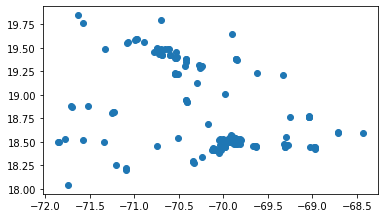

In [36]:
caipi = gpd.read_file(f'data/raw/caipi_raw.geojson').dropna(subset=['Latitud'])
cdisplay(caipi.head(2), caipi.shape, caipi.plot())

In [28]:
caipi.loc[0].to_dict()

{'Region': 'ESTE',
 'Provincia': 'LA ALTAGRACIA',
 'Municipio': 'HIGuEY',
 'NumCentro': 1,
 'Centro': 'LA MALENA',
 'Tipo': 'CAIPI',
 'Direccion': 'CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, MUNICIPIO SALVALEoN DE HIGuEY.',
 'Latitud': 18.59188,
 'Longitud': -68.71111,
 'geometry': <shapely.geometry.point.Point at 0x274cfb1df88>}

In [ ]:
new_caipi = {
 'Region': 'ESTE',
 'Provincia': 'LA ALTAGRACIA',
 'Municipio': 'HIGuEY',
 'NumCentro': 1,
 'Centro': 'LA MALENA',
 'Tipo': 'CAIPI',
 'Direccion': 'CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, MUNICIPIO SALVALEoN DE HIGuEY.',
 'Latitud': 18.59188,
 'Longitud': -68.71111}

#### CAID

,Provincia,Municipio,municipio,Dirección,Lat,Long,geometry
0,San Juan de la Maguana,San Juan,"2201 – San Juan, San Juan","KM 5, carretera San Juan-Azua",18.787103,-71.194196,POINT (-71.19420 18.78710)
1,Santiago de los Caballeros,Santiago,"2501 – Santiago, Santiago","Av. Hispanoamericana, 51000, Barrio Pekín",19.429112,-70.685306,POINT (-70.68531 19.42911)


(3, 7)

<AxesSubplot:>

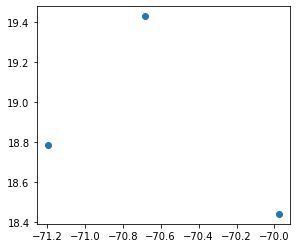

In [12]:
df_caid_raw = pd.read_excel( 'data/raw/caid_raw.xlsx')

# transform to geo data frame
gdf_caid = df_caid_raw.copy()
gdf_caid.loc[:, 'geometry'] = gdf_caid[[
    'Long', 'Lat']].apply(
        lambda *args: Point(tuple(*args)), axis=1)

gdf_caid = gpd.GeoDataFrame(
    gdf_caid, crs="EPSG:4326", geometry='geometry')
cdisplay(gdf_caid.head(2), gdf_caid.shape, gdf_caid.plot())

#### MIN Mujer

,Municipio,municipality_key,geometry
0,Azua,0201,POINT (-70.74774 18.45327)
1,Barahona,0401,POINT (-71.09750 18.20913)


(46, 3)

<AxesSubplot:>

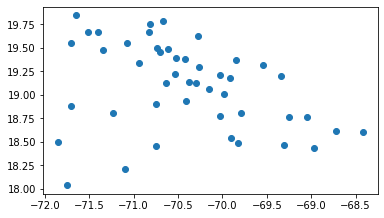

In [13]:
gdf_minmujer = gpd.read_file('data/raw/minmujer_raw.geojson')
display(gdf_minmujer.head(2), gdf_minmujer.shape, gdf_minmujer.plot())

#### Other Centers

found path: C:\Users\aleja\Dropbox\Github\criteria-dominicana\data/geo/geocodificar/output\all-geocoded-20210625T1555Z.geojson


,level_0,itm,_query,municipio,region,components,language,address,longitude,latitude,formatted_address,place_id,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,nombre,direccion,provincia,municipality_key,capacidad,has_epes,geometry
0,ASFL DIURNAS,1,"C/Selene, Bella Vista, Distrito Nacional",None,None,{'country': 'DO'},es,"Av Selene, Santo Domingo, República Dominicana",-69.944024,18.449356,"Av Selene, Santo Domingo, República Dominicana",ChIJ51KhbRpipY4RnZkp-ciEDRU,18.453051,-69.93861,18.44616,-69.949264,18.449356,-69.944024,GEOMETRIC_CENTER,18.453051,-69.938610,18.446160,-69.949264,None,None,None,Fundacion Mis Abuelos Y Yo,None,None,0101,2.0,False,POINT (-69.94402 18.44936)
1,ASFL DIURNAS,2,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuproden...,None,None,{'country': 'DO'},es,"Higuero, Santo Domingo, República Dominicana",-69.925600,18.584638,"Higuero, Santo Domingo, República Dominicana",ChIJoVi91O2Or44RR__U2iw6TFY,NaN,NaN,NaN,NaN,18.584638,-69.925600,GEOMETRIC_CENTER,18.585987,-69.924251,18.583289,-69.926948,1,"H3MF+VQ Santo Domingo, República Dominicana",77CGH3MF+VQ,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuprodenty),None,None,3203,36.0,False,POINT (-69.92560 18.58464)


(472, 33)

<AxesSubplot:>

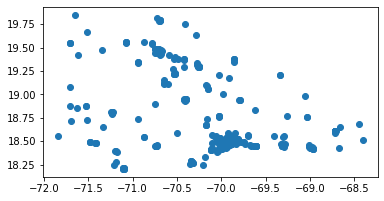

In [14]:
gdf_othcercenters = gpd.read_file('data/raw/othercenters_raw.geojson').dropna(subset=['latitude'])

# Prosoli regional bureau  Norcentral II does not exist, according to Jorge 
# message on June 21.
gdf_othcercenters.drop(
    gdf_othcercenters.index[
        gdf_othcercenters.level_0.eq('prosoli') & gdf_othcercenters.itm.eq(
            9)], inplace=True)
cdisplay(gdf_othcercenters.head(2), gdf_othcercenters.shape, gdf_othcercenters.plot() )



### Influence Areas

29
32
36


,cartodb_id,center,data_range,source_cartodb_id,region,provincia,municipio,numcentro,centro,tipo,direccion,latitud,longitud,geometry
0,1,0101000020E61000006A1327F73B7651C01F9DBAF2595E...,600,9,NORTE ORIENTAL,MARiA TRINIDAD SaNCHEZ,NAGUA,9,SAN JOSE DE VILLA,CAIPI,M. T. SaNCHEZ / NAGUA,19.36856,-69.84741,"MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ..."
1,2,0101000020E6100000F37684D3822D51C00F289B728597...,600,1,ESTE,LA ALTAGRACIA,HIGuEY,1,LA MALENA,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",18.59188,-68.71111,"MULTIPOLYGON (((-68.73399 18.58286, -68.73373 ..."


(156, 14)

<AxesSubplot:>

Index(['cartodb_id', 'center', 'data_range', 'source_cartodb_id', 'region',
       'provincia', 'municipio', 'numcentro', 'centro', 'tipo', 'direccion',
       'latitud', 'longitud', 'geometry'],
      dtype='object')

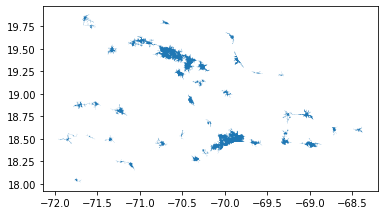

In [15]:
gdf_caipiarea = gpd.read_file('data/raw/caipi_influencearea_raw.geojson')

# before correction
# gdf_caipiarea[gdf_caipiarea.numcentro.isin([29, 32, 36])].plot()
for idx, geometry in gpd.read_file('data/raw/caipi_inconsistent_raw.geojson').set_index('n_centro')['geometry'].iteritems():
    print(idx)
    gdf_caipiarea.loc[
        gdf_caipiarea.numcentro.eq(idx), 'geometry'] = geometry
cdisplay(gdf_caipiarea.head(2), gdf_caipiarea.shape, gdf_caipiarea.plot())
gdf_caipiarea.columns

In [16]:
gdf_caidminmujer_area = gpd.read_file('data/raw/caidminmujer_area_raw.geojson')
gdf_caidminmujer_area.head(2)


,cartodb_id,center,data_range,source_cartodb_id,name,capacity,tipo,direccion,itm,municipality_key,geometry
0,1,0101000020E6100000F558DCB36DCC51C072FBA78E7FC9...,600,1,CAID San Juan,None,CAID,"KM 5, carretera San Juan-Azua",0,2201,"MULTIPOLYGON (((-71.26539 18.81409, -71.26282 ..."
1,2,0101000020E61000006F160F0CDCAB51C00653F54BDA6D...,600,2,CAID Santiago,None,CAID,"Av. Hispanoamericana, 51000, Barrio Pekín",1,2501,"MULTIPOLYGON (((-70.73805 19.42383, -70.73547 ..."


In [17]:
gdf_otherareas1 = gpd.read_file('data/raw/otherareas1_raw.geojson').dropna(subset=['latitude'])

# drop care center category as agreed 
gdf_otherareas1 = gdf_otherareas1[lambda df: df.level_0.ne(
    'HARAS NACIONALES')]
# Prosoli regional bureau  Norcentral II does not exist, according to Jorge 
# message on June 21.
gdf_otherareas1.drop(
    gdf_otherareas1.index[
        gdf_otherareas1.level_0.eq('prosoli') & \
            gdf_otherareas1.itm.eq(9)], inplace=True)

# join columns which were not added in this geolocation process
gdf_otherareas1 = gdf_otherareas1.merge(gdf_othcercenters[[
    'level_0', 'itm', 'municipality_key', 'direccion', 'nombre']], on=[
    'level_0', 'itm'])

gdf_otherareas2 = gpd.read_file('data/raw/otherareas1_raw.geojson').dropna(subset=['latitude'])

other_located_areas = pd.concat((
    gdf_otherareas1, gdf_otherareas2), ignore_index=True)
cdisplay(other_located_areas.head(2), other_located_areas.shape, other_located_areas.columns )

,cartodb_id,center,data_range,source_cartodb_id,level_0,itm,_query,municipio,region,components,language,address,longitude,latitude,formatted_address,place_id,geometry_bounds_northeast_lat,geometry_bounds_northeast_lng,geometry_bounds_southwest_lat,geometry_bounds_southwest_lng,geometry_location_lat,geometry_location_lng,geometry_location_type,geometry_viewport_northeast_lat,geometry_viewport_northeast_lng,geometry_viewport_southwest_lat,geometry_viewport_southwest_lng,partial_match,plus_code_compound_code,plus_code_global_code,geometry,municipality_key,direccion,nombre,provincia
0,1,0101000020E6100000D9322ABABFD551C0EB4B80AB867A...,600,105,ASFL PERMANENTES ONGS,18,"C/Santiago Rodriguez No. 6, Provincia San Juan...",None,None,{'country': 'DO'},es,"Santiago Rodríguez, República Dominicana",-71.339827,19.478617,"Santiago Rodríguez, República Dominicana",ChIJnU2mu3UDsY4RtuOgExPlVwM,19.576825,-71.077057,19.216424,-71.5556,19.478617,-71.339827,APPROXIMATE,19.576825,-71.077057,19.216424,-71.555600,None,None,None,"MULTIPOLYGON (((-71.39173 19.43619, -71.39088 ...",2601,None,"Hogar de Ancianos San Juan, Inc",NaN
1,7,0101000020E61000006A6CAF053D7B51C03782F9D0AA95...,600,2,ASFL DIURNAS,2,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuproden...,None,None,{'country': 'DO'},es,"Higuero, Santo Domingo, República Dominicana",-69.925600,18.584638,"Higuero, Santo Domingo, República Dominicana",ChIJoVi91O2Or44RR__U2iw6TFY,NaN,NaN,NaN,NaN,18.584638,-69.925600,GEOMETRIC_CENTER,18.585987,-69.924251,18.583289,-69.926948,1,"H3MF+VQ Santo Domingo, República Dominicana",77CGH3MF+VQ,"MULTIPOLYGON (((-69.97939 18.59505, -69.97261 ...",3203,None,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuprodenty),NaN


(496, 35)

Index(['cartodb_id', 'center', 'data_range', 'source_cartodb_id', 'level_0',
       'itm', '_query', 'municipio', 'region', 'components', 'language',
       'address', 'longitude', 'latitude', 'formatted_address', 'place_id',
       'geometry_bounds_northeast_lat', 'geometry_bounds_northeast_lng',
       'geometry_bounds_southwest_lat', 'geometry_bounds_southwest_lng',
       'geometry_location_lat', 'geometry_location_lng',
       'geometry_location_type', 'geometry_viewport_northeast_lat',
       'geometry_viewport_northeast_lng', 'geometry_viewport_southwest_lat',
       'geometry_viewport_southwest_lng', 'partial_match',
       'plus_code_compound_code', 'plus_code_global_code', 'geometry',
       'municipality_key', 'direccion', 'nombre', 'provincia'],
      dtype='object')

### Non geolocated care and training centers

In [18]:
df_ctc = pd.read_excel(f'data/raw/ctc_raw.xlsx', skiprows=1, header=[0, 1]).dropna(how='all', axis=1).drop_duplicates()
ctc_cols = ['NOMBRE DEL CTC', 'PROVINCIA', 'Municipio', 'CAPACIDAD FISICA']
df_ctc.columns = [s.lower() for s in ctc_cols]
cdisplay(df_ctc.head(2), df_ctc.shape)

,nombre del ctc,provincia,municipio,capacidad fisica
0,Arroyo Cano,SAN JUAN,Bohechío,40
1,Baitoa,SANTIAGO,Santiago,40


(72, 4)

## Centers with boundaries

- CTC's are already covered as their boundaries coincide with municipality boundaries.
- INFOTEP and PROSOLI regional bureaux are loaded.

### INFOTEP

In [19]:
df_infotep = pd.read_excel(f'data/raw/infotep_raw.xlsx', skiprows=4).dropna(how='all', axis=1).fillna(method='ffill')
df_infotep.columns = df_infotep.columns.str.lower()
cdisplay(df_infotep.head(2), df_infotep.shape, df_infotep.columns)

,direccion regional,servicios formacion profesional y oficina satelite,provincia,nombre,direccion
0,Dirección Regional Central,Departamento de Servicios Formacion Profesion...,Distrito Nacional,Dirección Regional Central,Autopista Duarte km. 6 1/2 D.N
1,Dirección Regional Central,Departamento de Servicios Formacion Profesion...,Santo Domingo,Dirección Regional Central,Autopista Duarte km. 6 1/2 D.N


(33, 5)

Index(['direccion regional',
       'servicios formacion  profesional y oficina satelite', 'provincia',
       'nombre', 'direccion'],
      dtype='object')

### PROSOLI

In [20]:
df_prosoli = pd.read_excel(f'data/raw/prosoli_raw.xlsx',skiprows=4).dropna(subset=['parsed_provincia'])
df_prosoli.columns = name_normalizer(df_prosoli.columns)
cdisplay(df_prosoli.head(2), df_prosoli.shape, df_prosoli.columns)

,provincia,parsed_provincia,telefono,direccion,direccion_regional,match
1,LA VEGA,LA VEGA,809-573-4267,"C/Pedro J. Casado #19,Esquina Av. Imbert",REGIONAL CENTRAL,Directora Regional Cibao Central
2,SANCHEZ RAMIREZ,SANCHEZ RAMIREZ,809-240-1781,"C/Juan Sánchez Ramírez, Próximo A Banco Ademis",REGIONAL CENTRAL,Directora Regional Cibao Central


(36, 6)

Index(['provincia', 'parsed_provincia', 'telefono', 'direccion',
       'direccion_regional', 'match'],
      dtype='object')

## Center Capacities

### CAIPI capacities

In [31]:
caipi_capacity_panel = pd.read_pickle(get_path_from_pattern(
    f'{data_dir}/other/capacidad-caipi/mean-capacity-muni-panel-*.pk'
))
caipi_capacity_dict = caipi_capacity_panel['2021-02-15'].to_dict()

## MISC

### Dissolve CAIPI Areas

In [22]:

if not dissolve_influence_areas:
    print('CAIPI influence areas are not dissolved')
    caipi_areas_gdf = gdf_caipiarea.assign(
        influence_area=lambda df: df['numcentro'], 
        influence_area_name=lambda df: df['centro'])
else:
    #---------- IGNORE THIS SECTION-----------
    # connected component algorithm from 
    # https://gis.stackexchange.com/questions/271733/geopandas-dissolve-
    # overlapping-polygons
    # Currently created with Carto 
    car_influence_gsrs = gdf_caipiarea.geometry

    overlap_matrix = car_influence_gsrs.apply(
        lambda x: car_influence_gsrs.overlaps(x)).values.astype(int)

    overlap_matrix

    n, ids = connected_components(overlap_matrix)
    print(f'number of connected components: {n}')

    _, counts = np.unique(ids, return_counts=True)

    gdf_caipiarea.loc[:, 'influence_area'] = ids 

    dissolved_car_gdf = gdf_caipiarea.dissolve('influence_area')
    dissolved_car_gdf['influence_area_name'] = name_normalizer(
        dissolved_car_gdf.provincia).str.replace(' ', '_').str.cat(
        dissolved_car_gdf.groupby('provincia').cumcount().add(1).astype(str),
        sep='_')
    dissolved_car_gdf['caipi_sum'] = counts
    caipi_areas_gdf = dissolved_car_gdf
    

CAIPI influence areas are not dissolved


# Transform Care Centers

## Joins

### CAIPI - Municipios

In [35]:
normalized_muni_col = 'norm_municipio'
caipi_pre_concat_assign_map = {
    # municipality key to caipi
    normalized_muni_col: lambda df: name_normalizer(df.municipio).str.replace(
        'bisono (navarrete)', 'bisono', regex=False), 
    'municipality_key' : lambda df: df.merge(gdf_municipalities.assign(**{
        normalized_muni_col: lambda df: name_normalizer(df.Municipio)})[[
        normalized_muni_col, 'municipality_key'
    ]], how='left')['municipality_key'].values,

    'municipality_key' : lambda df: df.merge(gdf_municipalities.assign(**{
        normalized_muni_col: lambda df: name_normalizer(df.Municipio)})[[
        normalized_muni_col, 'municipality_key'
    ]], how='left')['municipality_key'].values,
    
    'capacity': lambda df: df['municipality_key'].map(
        caipi_capacity_dict).round(0).astype(int)
}

caipi_pre_concat_assign_transformer = AssignTransformer(
    caipi_pre_concat_assign_map)

caipi_merged_gdf = caipi.copy()
caipi_merged_gdf.columns = caipi_merged_gdf.columns.str.lower()
caipi_merged_gdf = caipi_pre_concat_assign_transformer.transform(
    caipi_merged_gdf)
shw(caipi_merged_gdf)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

### CAIPI - Neighborhoods

,region,provincia,municipio,numcentro,centro,tipo,direccion,latitud,longitud,geometry,norm_municipio_left,capacity,index_right,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,municipality_key,Municipio,norm_municipio_right,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,ESTE,LA ALTAGRACIA,HIGuEY,1,LA MALENA,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",18.59188,-68.71111,POINT (-68.71111 18.59188),higuey,290,11967,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Altagracia,Provincia La Altagracia,DO1002,Municipio Higüey,Municipio Higuey,DO100201,La Altagracia,11,Higüey,Salvaleón de Higüey,1101,Higüey,higuey,4.0,11,01,01,01,032,La Malena,08,1,0811010101032,08110101101032,11010101032,1.0
1,ESTE,LA ALTAGRACIA,HIGuEY,2,LA CRISTINITA,CAIPI,"BARRIO CRISTINITA, CALLE ENTRADA CRISTINITA (A...",18.59381,-68.43489,POINT (-68.43489 18.59381),higuey,290,12292,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Altagracia,Provincia La Altagracia,DO1002,Municipio Higüey,Municipio Higuey,DO100201,La Altagracia,11,Higüey,Salvaleón de Higüey,1101,Higüey,higuey,4.0,11,01,03,04,027,Las Dos Jardas,08,2,0811010304027,08110103204027,11010304027,1.0


(156, 45)

<AxesSubplot:>

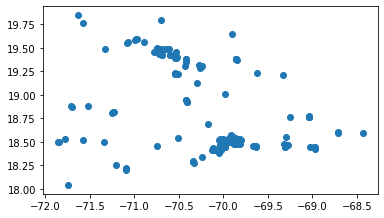

In [24]:
#MERGE
caipi_barrios_gdf = gpd.sjoin(caipi_merged_gdf[['region', 'provincia', 'municipio', 'numcentro', 'centro', 'tipo',
       'direccion', 'latitud', 'longitud', 'geometry', 'norm_municipio','capacity']],  neighborhood_gdf,  op='within')
shw(caipi_barrios_gdf)

In [25]:
print(caipi_merged_gdf.columns)
print(neighborhood_gdf.columns)


Index(['region', 'provincia', 'municipio', 'numcentro', 'centro', 'tipo',
       'direccion', 'latitud', 'longitud', 'geometry', 'norm_municipio',
       'municipality_key', 'capacity'],
      dtype='object')
Index(['ADM0_EN', 'ADM0_ES', 'ADM0_PCODE', 'ADM1_ES', 'ADM1_REF', 'ADM1_PCODE',
       'ADM2_ES', 'ADM2_REF', 'ADM2_PCODE', 'ADM3_ES', 'ADM3_REF',
       'ADM3_PCODE', 'Provincia', 'Código de   provincia',
       'Municipio cabecera', 'Ciudad capital', 'municipality_key', 'Municipio',
       'norm_municipio', 'caipi_sum', 'PROV', 'MUN', 'DM', 'SECC', 'BP',
       'TOPONIMIA', 'REG', 'ZONA', 'ENLACE', 'CODIGO', 'neighborhood_key',
       'caipi_sum_neighbor', 'geometry'],
      dtype='object')


### CTC

C:\Users\aleja\anaconda3\envs\criteria-do\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


,Municipio,municipality_key,geometry,nombre del ctc,provincia,municipio,capacidad fisica,tipo,direccion,itm
0,Castillo,0603,POINT (-70.03406 19.23477),Castillo,DUARTE,Castillo,40,CTC con EPES,NaN,6
1,Villa Riva,0605,POINT (-69.88369 19.15048),Villa riva,Duarte,Villa Riva,40,CTC con EPES,NaN,69


(72, 10)

<AxesSubplot:>

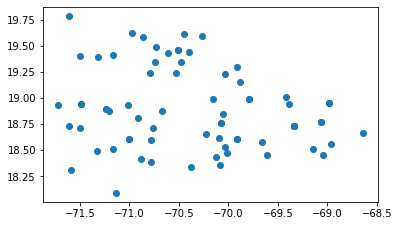

In [26]:
ctc_muni_src_df = df_ctc.copy()
ctc_muni_src_df = ctc_muni_src_df.assign(
    tipo='CTC con EPES', direccion=np.nan, 
    itm=lambda df: range(1, df.shape[0] + 1))

ctc_muni_src_df['Municipio'] = df_ctc.municipio.map(
        lambda x: get_close_matches(
            x, gdf_municipalities.Municipio.values, n=1)[0])

ctc_muni_src_gdf = gdf_municipalities[[
    'Municipio', 'municipality_key', 'geometry']].merge(
    ctc_muni_src_df)
# for care centers geojson
ctc_muni_centroids_gdf = ctc_muni_src_gdf.copy()
ctc_muni_centroids_gdf['geometry'] = ctc_muni_centroids_gdf[
    'geometry'].centroid.to_crs(crs="EPSG:4326")

shw(ctc_muni_centroids_gdf)

### CTC - Barrios

,Municipio_left,geometry,nombre del ctc,provincia,municipio,capacidad fisica,tipo,direccion,itm,index_right,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,municipality_key,Municipio_right,norm_municipio,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,Castillo,POINT (-70.03406 19.23477),Castillo,DUARTE,Castillo,40,CTC con EPES,NaN,6,74,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Castillo,Municipio Castillo,DO010103,Duarte,6,San Francisco de Macorís,San Francisco de Macorís,0603,Castillo,castillo,0.0,06,03,01,03,010,Juana Díaz Arriba,03,2,0306030103010,03060301203010,06030103010,NaN
1,Villa Riva,POINT (-69.88369 19.15048),Villa riva,Duarte,Villa Riva,40,CTC con EPES,NaN,69,572,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Villa Riva,Municipio Villa Riva,DO010105,Duarte,6,San Francisco de Macorís,San Francisco de Macorís,0605,Villa Riva,villa riva,0.0,06,05,01,02,001,Ceiba De Los Pájaros,03,2,0306050102001,03060501202001,06050102001,NaN


(72, 42)

<AxesSubplot:>

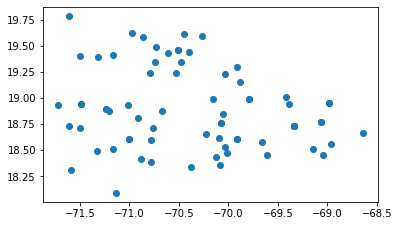

In [27]:
duplicated_columns = ['municipality_key', 'index']

ctc_neigh_centroids_gdf = ctc_muni_centroids_gdf.copy()
non_duplicated_columns = [x for x in ctc_neigh_centroids_gdf.columns if x not in duplicated_columns]

ctc_neigh_centroids_gdf = gpd.sjoin(ctc_neigh_centroids_gdf[non_duplicated_columns], neighborhood_gdf, op='within')
shw(ctc_neigh_centroids_gdf)

### CAID

,Provincia,Municipio,municipio,Dirección,Lat,Long,geometry,name,capacity,tipo,itm,municipality_key
0,San Juan de la Maguana,San Juan,"2201 – San Juan, San Juan","KM 5, carretera San Juan-Azua",18.787103,-71.194196,POINT (-71.19420 18.78710),CAID San Juan,NaN,CAID,0,2201
1,Santiago de los Caballeros,Santiago,"2501 – Santiago, Santiago","Av. Hispanoamericana, 51000, Barrio Pekín",19.429112,-70.685306,POINT (-70.68531 19.42911),CAID Santiago,NaN,CAID,1,2501


(3, 12)

<AxesSubplot:>

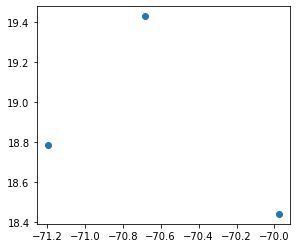

In [28]:
caid_to_merge_gdf = gdf_caid.assign(**{
    'name': lambda df: 'CAID ' + df['Municipio'],
    'capacity': np.nan,
    'tipo': 'CAID',
    'itm': lambda df: df.index,
    'municipality_key': lambda df: df['municipio'].str.extract('(\d{4})')
})
shw(caid_to_merge_gdf)

### CAID - Barrios

In [29]:
caid_to_merge_gdf.columns

Index(['Provincia', 'Municipio', 'municipio', 'Dirección', 'Lat', 'Long',
       'geometry', 'name', 'capacity', 'tipo', 'itm', 'municipality_key'],
      dtype='object')

,Provincia,Municipio,municipio,Dirección,Lat,Long,geometry,name,capacity,tipo,itm,municipality_key,index_right,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Código de provincia,Municipio cabecera,Ciudad capital,norm_municipio,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,San Juan de la Maguana,San Juan,"2201 – San Juan, San Juan","KM 5, carretera San Juan-Azua",18.787103,-71.194196,POINT (-71.19420 18.78710),CAID San Juan,NaN,CAID,0,2201,6982,Dominican Republic,República Dominicana,DO,Región El Valle,Region El Valle,DO05,Provincia San Juan,Provincia San Juan,DO0502,Municipio San Juan,Municipio San Juan,DO050201,22,San Juan de la Maguana,San Juan de la Maguana,san juan,4.0,22,01,05,02,003,Los Cambrones,07,2,0722010502003,07220105202003,22010502003,NaN
1,Santiago de los Caballeros,Santiago,"2501 – Santiago, Santiago","Av. Hispanoamericana, 51000, Barrio Pekín",19.429112,-70.685306,POINT (-70.68531 19.42911),CAID Santiago,NaN,CAID,1,2501,4402,Dominican Republic,República Dominicana,DO,Región Cibao Norte,Region Cibao Norte,DO03,Provincia Santiago,Provincia Santiago,DO0303,Municipio Santiago,Municipio Santiago,DO030301,25,Santiago,Santiago de Los Caballeros,santiago,13.0,25,01,01,01,057,Villa Olímpica,01,1,0125010101057,01250101101057,25010101057,NaN


(3, 42)

<AxesSubplot:>

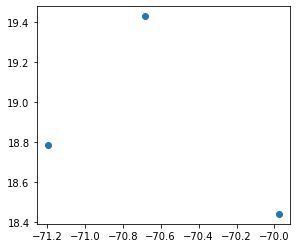

In [30]:
caid_to_merge_gdf = gdf_caid.assign(**{
    'name': lambda df: 'CAID ' + df['Municipio'],
    'capacity': np.nan,
    'tipo': 'CAID',
    'itm': lambda df: df.index,
    'municipality_key': lambda df: df['municipio'].str.extract('(\d{4})')
})

nonrepeated_cols = non_repeated_columns(caid_to_merge_gdf, neighborhood_gdf, [], [], True)
caid_neigh_gdf = gpd.sjoin(caid_to_merge_gdf, neighborhood_gdf[nonrepeated_cols])
shw(caid_neigh_gdf)


### Ministerio de la Mujer

In [31]:
min_mujer_to_merge_gdf = gdf_minmujer.assign(**{
    'name': lambda df: 'Oficina de la Mujer ' + df['Municipio'],
    'capacity': np.nan,
    'tipo': 'Oficina de la Mujer',
    'direccion': np.nan,
    'itm': lambda df: df.index,
})
min_mujer_to_merge_gdf.head()

,Municipio,municipality_key,geometry,name,capacity,tipo,direccion,itm
0,Azua,0201,POINT (-70.74774 18.45327),Oficina de la Mujer Azua,NaN,Oficina de la Mujer,NaN,0
1,Barahona,0401,POINT (-71.09750 18.20913),Oficina de la Mujer Barahona,NaN,Oficina de la Mujer,NaN,1
2,Comendador,0701,POINT (-71.70565 18.87865),Oficina de la Mujer Comendador,NaN,Oficina de la Mujer,NaN,2
3,Jimaní,1001,POINT (-71.84928 18.49438),Oficina de la Mujer Jimaní,NaN,Oficina de la Mujer,NaN,3
4,Pedernales,1601,POINT (-71.74474 18.03681),Oficina de la Mujer Pedernales,NaN,Oficina de la Mujer,NaN,4


### Ministerio de la Mujer -  Neighborhoods

,Municipio,municipality_key,geometry,name,capacity,tipo,direccion,itm,index_right,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,norm_municipio,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,Azua,0201,POINT (-70.74774 18.45327),Oficina de la Mujer Azua,NaN,Oficina de la Mujer,NaN,0,10039,Dominican Republic,República Dominicana,DO,Región Valdesia,Region Valdesia,DO09,Provincia Azua,Provincia Azua,DO0901,Municipio Azua,Municipio Azua,DO090101,Azua,2,Azua,Azua de Compostela,azua,2.0,02,01,01,01,003,La Bombita,05,1,0502010101003,05020101101003,02010101003,NaN
1,Barahona,0401,POINT (-71.09750 18.20913),Oficina de la Mujer Barahona,NaN,Oficina de la Mujer,NaN,1,7577,Dominican Republic,República Dominicana,DO,Región Enriquillo,Region Enriquillo,DO06,Provincia Barahona,Provincia Barahona,DO0602,Municipio Barahona,Municipio Barahona,DO060201,Barahona,4,Barahona,Santa Cruz de Barahona,barahona,3.0,04,01,01,01,022,Centro De La Ciudad,06,1,0604010101022,06040101101022,04010101022,NaN


(46, 39)

<AxesSubplot:>

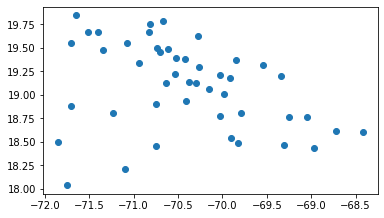

In [32]:
nonrepeated_cols = non_repeated_columns(min_mujer_to_merge_gdf, neighborhood_gdf, [], [], True)
min_mujer_neigh_gdf = gpd.sjoin(min_mujer_to_merge_gdf, neighborhood_gdf[nonrepeated_cols])
shw(min_mujer_neigh_gdf)

### Other geolocated centers

,level_0,itm,_query,municipio,region,components,language,address,longitude,latitude,formatted_address,place_id,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,nombre,direccion,provincia,municipality_key,capacidad,has_epes,geometry,center_type
0,ASFL DIURNAS,1,"C/Selene, Bella Vista, Distrito Nacional",None,None,{'country': 'DO'},es,"Av Selene, Santo Domingo, República Dominicana",-69.944024,18.449356,"Av Selene, Santo Domingo, República Dominicana",ChIJ51KhbRpipY4RnZkp-ciEDRU,18.453051,-69.93861,18.44616,-69.949264,18.449356,-69.944024,GEOMETRIC_CENTER,18.453051,-69.938610,18.446160,-69.949264,None,None,None,Fundacion Mis Abuelos Y Yo,None,None,0101,2.0,False,POINT (-69.94402 18.44936),ASFL DIURNAS
1,ASFL DIURNAS,2,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuproden...,None,None,{'country': 'DO'},es,"Higuero, Santo Domingo, República Dominicana",-69.925600,18.584638,"Higuero, Santo Domingo, República Dominicana",ChIJoVi91O2Or44RR__U2iw6TFY,NaN,NaN,NaN,NaN,18.584638,-69.925600,GEOMETRIC_CENTER,18.585987,-69.924251,18.583289,-69.926948,1,"H3MF+VQ Santo Domingo, República Dominicana",77CGH3MF+VQ,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuprodenty),None,None,3203,36.0,False,POINT (-69.92560 18.58464),ASFL DIURNAS


(472, 34)

<AxesSubplot:>

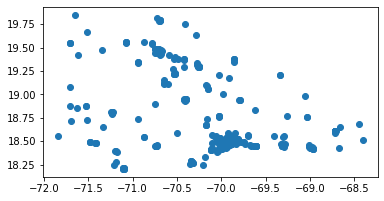

In [33]:
other_centers_pre_concat_select_map = {
    'center_type': {
        lambda df: df.level_0.eq('ccpp') & (~ df.has_epes): 
            'CCPP SIN EPES',
        lambda df: df.level_0.eq('ccpp') & df.has_epes: 
            'CCPP CON EPES',
        'default': lambda df: df['level_0']
    }
}

other_centers_pre_concat_select_transformer = SelectTransformer(
    other_centers_pre_concat_select_map)
other_centers_merged_gdf = gdf_othcercenters.pipe(
# .fillna({
#     'has_epes': False, 'capacidad': np.nan}).astype({'has_epes': bool})
other_centers_pre_concat_select_transformer.transform)
shw(other_centers_merged_gdf)

In [34]:
[x for x in neighborhood_gdf.columns if 'ind' in x]

[]

### Other geolocated centers - Barrios

,level_0,itm,_query,municipio,region,components,language,address,longitude,latitude,formatted_address,place_id,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,nombre,direccion,provincia,municipality_key,capacidad,has_epes,geometry,center_type,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,Municipio,norm_municipio,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,ASFL DIURNAS,1,"C/Selene, Bella Vista, Distrito Nacional",None,None,{'country': 'DO'},es,"Av Selene, Santo Domingo, República Dominicana",-69.944024,18.449356,"Av Selene, Santo Domingo, República Dominicana",ChIJ51KhbRpipY4RnZkp-ciEDRU,18.453051,-69.93861,18.44616,-69.949264,18.449356,-69.944024,GEOMETRIC_CENTER,18.453051,-69.93861,18.44616,-69.949264,None,None,None,Fundacion Mis Abuelos Y Yo,None,None,0101,2.0,False,POINT (-69.94402 18.44936),ASFL DIURNAS,Dominican Republic,República Dominicana,DO,Región Ozama,Region Ozama,DO08,Distrito Nacional,Distrito Nacional,DO0801,Municipio Santo Domingo de Guzmán,Municipio Santo Domingo de Guzman,DO080101,Distrito Nacional,1,Santo Domingo de Guzmán,Santo Domingo de Guzmán,Santo Domingo de Guzmán,santo domingo de guzman,9.0,01,01,01,01,030,Bella Vista,10,1,1001010101030,10010101101030,01010101030,NaN
40,ASFL DIURNAS,41,"C/Selene, Bella Vista, Distrito Nacional",None,None,{'country': 'DO'},es,"Av Selene, Santo Domingo, República Dominicana",-69.944024,18.449356,"Av Selene, Santo Domingo, República Dominicana",ChIJ51KhbRpipY4RnZkp-ciEDRU,18.453051,-69.93861,18.44616,-69.949264,18.449356,-69.944024,GEOMETRIC_CENTER,18.453051,-69.93861,18.44616,-69.949264,None,None,None,Instituto De Nefrologia Dr. Alberto Flores,None,None,0101,0.0,False,POINT (-69.94402 18.44936),ASFL DIURNAS,Dominican Republic,República Dominicana,DO,Región Ozama,Region Ozama,DO08,Distrito Nacional,Distrito Nacional,DO0801,Municipio Santo Domingo de Guzmán,Municipio Santo Domingo de Guzman,DO080101,Distrito Nacional,1,Santo Domingo de Guzmán,Santo Domingo de Guzmán,Santo Domingo de Guzmán,santo domingo de guzman,9.0,01,01,01,01,030,Bella Vista,10,1,1001010101030,10010101101030,01010101030,NaN


(470, 65)

<AxesSubplot:>

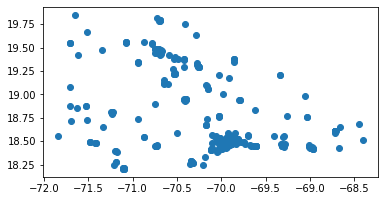

In [35]:
nonrepeated_cols = non_repeated_columns(other_centers_merged_gdf, neighborhood_gdf, [], [], True)
other_centers_neigh_gdf = gpd.sjoin(other_centers_merged_gdf, neighborhood_gdf[nonrepeated_cols], op='within').drop('index_right', axis=1)
shw(other_centers_neigh_gdf)

## Concatenate -  Municipio

concat_caipi: (156, 7), 
 concat_ctc: (72, 7) 
 concat_caid: (3, 7), 
 concat_min_mujer: (46, 7), 
 concat_other: (472, 7)


,name,capacity,tipo,direccion,itm,municipality_key,geometry
0,LA MALENA,290.0,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",1,1101,POINT (-68.71111 18.59188)
1,LA CRISTINITA,290.0,CAIPI,"BARRIO CRISTINITA, CALLE ENTRADA CRISTINITA (A...",2,1101,POINT (-68.43489 18.59381)


(749, 7)

<AxesSubplot:>

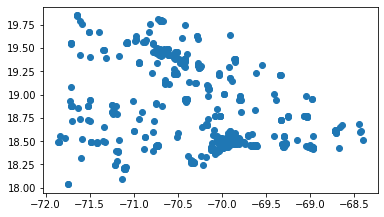

In [36]:
# target_column: [CAIPI, ctc, caid, min_mujer, other]
concat_map = {
    'name': ['centro', 'nombre del ctc', 'name', 'name', 'nombre'],
    'capacity': [
        'capacity', 'capacidad fisica', 'capacity', 'capacity', 'capacidad'], 
    'tipo': ['tipo', 'tipo', 'tipo', 'tipo', 'center_type'], 
    'direccion': [
        'direccion', 'direccion', 'Dirección', 'direccion', 'direccion'],
    'itm': ['numcentro', 'itm',  'itm', 'itm', 'itm']
}
keep_features = ['municipality_key', 'geometry']


def rename_to_concat(df, i, concat_map=concat_map, keep_features=keep_features):
    return NameTransformer({
        v[i]: k for k, v in concat_map.items()}, keep_features=keep_features
    ).transform(df) 

concat_caipi = rename_to_concat(caipi_merged_gdf, 0)
concat_ctc = rename_to_concat(ctc_muni_centroids_gdf, 1)
concat_caid = rename_to_concat(caid_to_merge_gdf, 2)
concat_min_mujer = rename_to_concat(min_mujer_to_merge_gdf, 3)
concat_other = rename_to_concat(other_centers_merged_gdf, 4)
print(f'concat_caipi: {concat_caipi.shape}, \n concat_ctc: {concat_ctc.shape} \n concat_caid: {concat_caid.shape}, \n concat_min_mujer: {concat_min_mujer.shape}, \n concat_other: {concat_other.shape}')
concat_centers = pd.concat((
    concat_caipi, concat_ctc, concat_caid, concat_min_mujer, concat_other), 
    ignore_index=True)
cdisplay(concat_centers.head(2), concat_centers.shape, concat_centers.plot())

## Concatenate - Barrio

In [37]:
caipi_barrios_gdf.columns

Index(['region', 'provincia', 'municipio', 'numcentro', 'centro', 'tipo',
       'direccion', 'latitud', 'longitud', 'geometry', 'norm_municipio_left',
       'capacity', 'index_right', 'ADM0_EN', 'ADM0_ES', 'ADM0_PCODE',
       'ADM1_ES', 'ADM1_REF', 'ADM1_PCODE', 'ADM2_ES', 'ADM2_REF',
       'ADM2_PCODE', 'ADM3_ES', 'ADM3_REF', 'ADM3_PCODE', 'Provincia',
       'Código de   provincia', 'Municipio cabecera', 'Ciudad capital',
       'municipality_key', 'Municipio', 'norm_municipio_right', 'caipi_sum',
       'PROV', 'MUN', 'DM', 'SECC', 'BP', 'TOPONIMIA', 'REG', 'ZONA', 'ENLACE',
       'CODIGO', 'neighborhood_key', 'caipi_sum_neighbor'],
      dtype='object')

concat_caipi: (156, 8), 
 concat_ctc: (72, 8) 
 concat_caid: (3, 8), 
 concat_min_mujer: (46, 8), 
 concat_other: (470, 8)


,name,capacity,tipo,direccion,itm,municipality_key,neighborhood_key,geometry
0,LA MALENA,290.0,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",1,1101,11010101032,POINT (-68.71111 18.59188)
1,LA CRISTINITA,290.0,CAIPI,"BARRIO CRISTINITA, CALLE ENTRADA CRISTINITA (A...",2,1101,11010304027,POINT (-68.43489 18.59381)


(747, 8)

<AxesSubplot:>

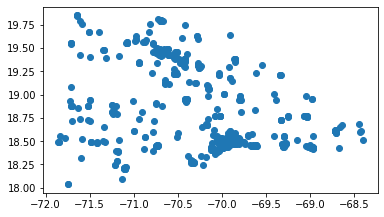

In [38]:
# target_column: [CAIPI, ctc, caid, min_mujer, other]
concat_map = {
    'name': ['centro', 'nombre del ctc', 'name', 'name', 'nombre'],
    'capacity': [
        'capacity', 'capacidad fisica', 'capacity', 'capacity', 'capacidad'], 
    'tipo': ['tipo', 'tipo', 'tipo', 'tipo', 'center_type'], 
    'direccion': [
        'direccion', 'direccion', 'Dirección', 'direccion', 'direccion'],
    'itm': ['numcentro', 'itm',  'itm', 'itm', 'itm']
}
keep_features = ['municipality_key', 'neighborhood_key', 'geometry']


def rename_to_concat(df, i, concat_map=concat_map, keep_features=keep_features):
    return NameTransformer({
        v[i]: k for k, v in concat_map.items()}, keep_features=keep_features
    ).transform(df) 

concat_caipi = rename_to_concat(caipi_barrios_gdf, 0)
concat_ctc = rename_to_concat(ctc_neigh_centroids_gdf, 1)
concat_caid = rename_to_concat(caid_neigh_gdf, 2)
concat_min_mujer = rename_to_concat(min_mujer_neigh_gdf, 3)
concat_other = rename_to_concat(other_centers_neigh_gdf, 4)

print(f'concat_caipi: {concat_caipi.shape}, \n concat_ctc: {concat_ctc.shape} \n concat_caid: {concat_caid.shape}, \n concat_min_mujer: {concat_min_mujer.shape}, \n concat_other: {concat_other.shape}')


concat_neig_centers = pd.concat((
    concat_caipi, concat_ctc, concat_caid, concat_min_mujer, concat_other), 
    ignore_index=True)
shw(concat_neig_centers)

In [39]:
caipi_barrios_gdf.columns

Index(['region', 'provincia', 'municipio', 'numcentro', 'centro', 'tipo',
       'direccion', 'latitud', 'longitud', 'geometry', 'norm_municipio_left',
       'capacity', 'index_right', 'ADM0_EN', 'ADM0_ES', 'ADM0_PCODE',
       'ADM1_ES', 'ADM1_REF', 'ADM1_PCODE', 'ADM2_ES', 'ADM2_REF',
       'ADM2_PCODE', 'ADM3_ES', 'ADM3_REF', 'ADM3_PCODE', 'Provincia',
       'Código de   provincia', 'Municipio cabecera', 'Ciudad capital',
       'municipality_key', 'Municipio', 'norm_municipio_right', 'caipi_sum',
       'PROV', 'MUN', 'DM', 'SECC', 'BP', 'TOPONIMIA', 'REG', 'ZONA', 'ENLACE',
       'CODIGO', 'neighborhood_key', 'caipi_sum_neighbor'],
      dtype='object')

## Export - Municipio

In [40]:
assert concat_centers[['tipo', 'itm']].duplicated().sum() == 0, (
    f"There are duplicates in ID columns")

In [41]:
center_types = concat_centers.tipo.unique()
center_types_dict = dict(zip(sorted(center_types), range(1, len(
    center_types) + 1)))

In [42]:
center_types_dict

{'ASFL DIURNAS': 1,
 'ASFL PERMANENTES ONGS': 2,
 'CAID': 3,
 'CAIPI': 4,
 'CCPP CON EPES': 5,
 'CCPP SIN EPES': 6,
 'COS-Central': 7,
 'COS-Este': 8,
 'COS-Norte': 9,
 'COS-Sur': 10,
 'CTC con EPES': 11,
 'ESTANCIAS QUE SON DE  CONAPE': 12,
 'INFOTEP': 13,
 'NUEVOS CENTRO DE DIA CONAPE': 14,
 'Oficina de la Mujer': 15,
 'prosoli': 16}

,poblacion_objetivo,leyenda,nombre,id,capacidad,direccion,tipo,municipio,geometry
0,primera infancia,Primera Infancia - CAIPI,La Malena,040001,290.0,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",Primera Infancia - CAIPI,"1101 - Higüey, La Altagracia",POINT (-68.71111 18.59188)
1,primera infancia,Primera Infancia - CAIPI,La Cristinita,040002,290.0,"BARRIO CRISTINITA, CALLE ENTRADA CRISTINITA (A...",Primera Infancia - CAIPI,"1101 - Higüey, La Altagracia",POINT (-68.43489 18.59381)


(749, 9)

<AxesSubplot:>

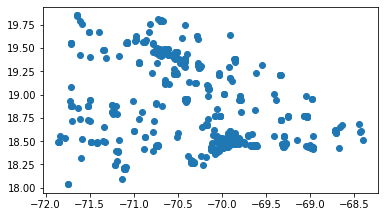

In [43]:
merge_municipalities = MergeTransformer(lambda: gdf_municipalities[[
    'municipality_key', 'Municipio', 'Provincia']])
export_select_map = {
    'objective_pop': {
        lambda df: df.tipo.isin(['ASFL PERMANENTES ONGS', 'ASFL DIURNAS',
           'ESTANCIAS QUE SON DE  CONAPE', 'NUEVOS CENTRO DE DIA CONAPE']): 
            'adulto mayor dependiente',
        lambda df: df.tipo.isin([
            'COS-Central', 'COS-Este', 'COS-Norte', 'COS-Sur', 'CCPP SIN EPES'
        ]): 'centro de formacion',
        lambda df: df.tipo.isin([
            'prosoli', 'INFOTEP', 'Oficina de la Mujer'
        ]): 'direccion regional',
        lambda df: df.tipo.isin(['CAIPI', 'CTC con EPES', 'CCPP CON EPES']): 
            'primera infancia',
        lambda df: df.tipo.eq('CAID'): 'situacion de discapacidad',
        'default': np.nan        
    },
}
export_assign_map = {
    # 'cap': lambda df: df['capacity'].astype('Int64'),
    'capacidad': lambda df: df['capacity'].fillna(df['objective_pop'].map(
        df.groupby('objective_pop')['capacity'].median().to_dict())),
    'id': lambda df: df['tipo'].map(center_types_dict).astype(str).str.zfill(
        2).str.cat(df.itm.astype(str).str.zfill(4)),
    'municipio': lambda df: df['municipality_key'].str.cat(
        df['Municipio'].str.cat(df['Provincia'], sep=', '),
        sep=' - '),
    'nombre': lambda df: name_normalizer(df['name']).str.title(),
    'leyenda': lambda df: df['tipo']
}

tipo_replace_map = {
    # Primera infancia
    **{c: f'Primera Infancia - {c.upper()}' for c in [
        'CAIPI', 'CCPP CON EPES', 'CTC con EPES']},
    # Adultos Mayores
    'ASFL DIURNAS': 'Adultos Mayores - ASFL DIURNAS',
    'ASFL PERMANENTES ONGS': 'Adultos Mayores - ASFL PERMANENTES',
    'ESTANCIAS QUE SON DE  CONAPE': 'Adultos Mayores - ESTANCIAS CONAPE',
    'NUEVOS CENTRO DE DIA CONAPE': 'Adultos Mayores - Nuevos C. de Dia CONAPE',
    # Discapacitados
    'CAID': 'Situacion de Discapacidad - CAID',
    # Centros de Formacion
    'CCPP SIN EPES': 'C. de Formacion - CCPP SIN EPES',
    **{c: 'C. de Formacion - COS INFOTEP' for c in [
        'COS-Central', 'COS-Este', 'COS-Norte', 'COS-Sur']},
    # Direcciones Regionales
    'prosoli': 'Direccion Regional PROSOLI',
    'INFOTEP': 'Direccion Regional INFOTEP',
}

export_replace_map = {
    'tipo': tipo_replace_map,
    'leyenda': {
        **tipo_replace_map,
        # Adultos Mayores
        **{type_: 'Adultos Mayores - Centros CONAPE' for type_ in [
            'ASFL DIURNAS', 'ASFL PERMANENTES ONGS', 
            'ESTANCIAS QUE SON DE  CONAPE', 'NUEVOS CENTRO DE DIA CONAPE'
        ]}
    }
}

export_name_map = {
    'objective_pop': 'poblacion_objetivo', 
}
export_name_keep = [
    'leyenda', 'nombre', 'id', 'capacidad', 'direccion', 'tipo', 'municipio', 'geometry'
]
export_centers = concat_centers\
    .pipe(merge_municipalities.transform)\
    .pipe(SelectTransformer(export_select_map).transform)\
    .pipe(AssignTransformer(export_assign_map).transform)\
    .pipe(ReplaceTransformer(export_replace_map, method='replace').transform)\
    .pipe(NameTransformer(export_name_map, export_name_keep).transform)

shw(export_centers)

In [44]:
inspect_nulls(export_centers)

capacidad    365
direccion    325
dtype: int64

In [45]:
concat_centers.pipe(merge_municipalities.transform).columns

Index(['name', 'capacity', 'tipo', 'direccion', 'itm', 'municipality_key',
       'geometry', 'Municipio', 'Provincia'],
      dtype='object')

In [46]:
assert export_centers.leyenda.nunique() <= 10, (
     'Carto legend will display some as "OTHERS"')
if not runall:
    protected_save(
        lambda gdf, path: gdf.to_file(path, driver="GeoJSON"), export_centers, 
        f'{data_dir}/geo/parsed/care-centers/care_centers-{timestamp}.geojson',
        ask_before_save=True
    )

## Export - Neighborhoods

In [47]:
neighborhood_gdf

,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,...,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor,geometry
0,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Arenoso,...,03,003,Rincón Bebedero,03,2,0306020203003,03060202203003,06020203003,NaN,"POLYGON ((-69.67577 19.17459, -69.67491 19.174..."
1,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Arenoso,...,03,002,El Guayabo,03,2,0306020203002,03060202203002,06020203002,NaN,"POLYGON ((-69.72082 19.22422, -69.69983 19.221..."
2,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Arenoso,...,02,001,Las Carreras,03,2,0306020202001,03060202202001,06020202001,NaN,"POLYGON ((-69.71262 19.14625, -69.71249 19.145..."
3,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Arenoso,...,02,004,Los Cacaos,03,2,0306020202004,03060202202004,06020202004,NaN,"POLYGON ((-69.72749 19.18725, -69.72912 19.182..."
4,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia Duarte,Provincia Duarte,DO0101,Municipio Arenoso,...,04,003,Los Chichones,03,2,0306020304003,03060203204003,06020304003,NaN,"POLYGON ((-69.77972 19.20191, -69.77976 19.200..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12560,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Romana,Provincia La Romana,DO1003,Municipio Villa Hermosa,...,01,015,Sinaí,08,1,0812030101015,08120301101015,12030101015,NaN,"POLYGON ((-69.00743 18.43547, -69.00726 18.434..."
12561,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Romana,Provincia La Romana,DO1003,Municipio Villa Hermosa,...,01,005,Villa Zorrilla,08,1,0812030101005,08120301101005,12030101005,NaN,"POLYGON ((-69.00679 18.44093, -69.00713 18.438..."
12562,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Romana,Provincia La Romana,DO1003,Municipio Villa Hermosa,...,01,004,Piedra Linda,08,1,0812030101004,08120301101004,12030101004,NaN,"POLYGON ((-69.00869 18.45137, -69.00747 18.450..."
12563,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Romana,Provincia La Romana,DO1003,Municipio Villa Hermosa,...,01,020,Los Mulos,08,1,0812030101020,08120301101020,12030101020,NaN,"POLYGON ((-69.02782 18.49119, -69.02606 18.491..."


,poblacion_objetivo,leyenda,nombre,id,capacidad,direccion,tipo,municipio,geometry,TOPONIMIA,neighborhood_key,barrio
0,primera infancia,Primera Infancia - CAIPI,La Malena,040001,290.0,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",Primera Infancia - CAIPI,"1101 - Higüey, La Altagracia",POINT (-68.71111 18.59188),La Malena,11010101032,"11010101032 - La Malena, Higüey, La Altagracia"
686,centro de formacion,C. de Formacion - COS INFOTEP,Fundacion Para La Capacitacion De Los Empleado...,080027,NaN,"C/ Aravelo #44, Sector la Malena, Higuey",C. de Formacion - COS INFOTEP,"1101 - Higüey, La Altagracia",POINT (-68.71188 18.59237),La Malena,11010101032,"11010101032 - La Malena, Higüey, La Altagracia"


(746, 12)

<AxesSubplot:>

capacidad    364
direccion    323
dtype: int64

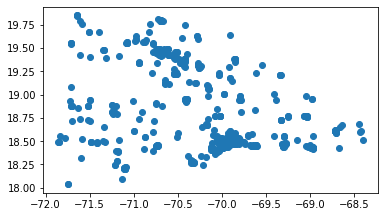

In [48]:
merge_neighborhoods = MergeTransformer(lambda: neighborhood_gdf[[
    'municipality_key', 'neighborhood_key', 'Municipio', 'Provincia', 'TOPONIMIA']])
export_select_map_neigh = {
    'objective_pop': {
        lambda df: df.tipo.isin(['ASFL PERMANENTES ONGS', 'ASFL DIURNAS',
           'ESTANCIAS QUE SON DE  CONAPE', 'NUEVOS CENTRO DE DIA CONAPE']): 
            'adulto mayor dependiente',
        lambda df: df.tipo.isin([
            'COS-Central', 'COS-Este', 'COS-Norte', 'COS-Sur', 'CCPP SIN EPES'
        ]): 'centro de formacion',
        lambda df: df.tipo.isin([
            'prosoli', 'INFOTEP', 'Oficina de la Mujer'
        ]): 'direccion regional',
        lambda df: df.tipo.isin(['CAIPI', 'CTC con EPES', 'CCPP CON EPES']): 
            'primera infancia',
        lambda df: df.tipo.eq('CAID'): 'situacion de discapacidad',
        'default': np.nan        
    },
}
export_assign_map_neigh= {
    # 'cap': lambda df: df['capacity'].astype('Int64'),
    'capacidad': lambda df: df['capacity'].fillna(df['objective_pop'].map(
        df.groupby('objective_pop')['capacity'].median().to_dict())),
    'id': lambda df: df['tipo'].map(center_types_dict).astype(str).str.zfill(
        2).str.cat(df.itm.astype(str).str.zfill(4)),
    'municipio': lambda df: df['municipality_key'].str.cat(
        df['Municipio'].str.cat(df['Provincia'], sep=', '),
        
        sep=' - '),
    
    'barrio': lambda df: df['neighborhood_key'].str.cat(
            df['TOPONIMIA'].str.cat( df['Municipio'].str.cat(df['Provincia'], sep=', ') , sep=', '), sep=' - '),

    'nombre': lambda df: name_normalizer(df['name']).str.title(),
    'leyenda': lambda df: df['tipo']
}

tipo_replace_map = {
    # Primera infancia
    **{c: f'Primera Infancia - {c.upper()}' for c in [
        'CAIPI', 'CCPP CON EPES', 'CTC con EPES']},
    # Adultos Mayores
    'ASFL DIURNAS': 'Adultos Mayores - ASFL DIURNAS',
    'ASFL PERMANENTES ONGS': 'Adultos Mayores - ASFL PERMANENTES',
    'ESTANCIAS QUE SON DE  CONAPE': 'Adultos Mayores - ESTANCIAS CONAPE',
    'NUEVOS CENTRO DE DIA CONAPE': 'Adultos Mayores - Nuevos C. de Dia CONAPE',
    # Discapacitados
    'CAID': 'Situacion de Discapacidad - CAID',
    # Centros de Formacion
    'CCPP SIN EPES': 'C. de Formacion - CCPP SIN EPES',
    **{c: 'C. de Formacion - COS INFOTEP' for c in [
        'COS-Central', 'COS-Este', 'COS-Norte', 'COS-Sur']},
    # Direcciones Regionales
    'prosoli': 'Direccion Regional PROSOLI',
    'INFOTEP': 'Direccion Regional INFOTEP',
}

export_replace_map_neigh = {
    'tipo': tipo_replace_map,
    'leyenda': {
        **tipo_replace_map,
        # Adultos Mayores
        **{type_: 'Adultos Mayores - Centros CONAPE' for type_ in [
            'ASFL DIURNAS', 'ASFL PERMANENTES ONGS', 
            'ESTANCIAS QUE SON DE  CONAPE', 'NUEVOS CENTRO DE DIA CONAPE'
        ]}
    }
}
export_name_map = {
    'objective_pop': 'poblacion_objetivo', 
}
export_name_keep = [
    'leyenda', 'nombre', 'id', 'capacidad', 'direccion', 'tipo', 'municipio', 'geometry', 'TOPONIMIA', 'neighborhood_key', 'barrio'
]
export_neig_centers = concat_neig_centers\
    .pipe(merge_neighborhoods.transform)\
    .pipe(SelectTransformer(export_select_map_neigh).transform)\
    .pipe(AssignTransformer(export_assign_map_neigh).transform)\
    .pipe(ReplaceTransformer(export_replace_map_neigh, method='replace').transform)\
    .pipe(NameTransformer(export_name_map, export_name_keep).transform)
shw(export_neig_centers)
inspect_nulls(export_neig_centers)

In [49]:
concat_neig_centers.columns

Index(['name', 'capacity', 'tipo', 'direccion', 'itm', 'municipality_key',
       'neighborhood_key', 'geometry'],
      dtype='object')

In [50]:
export_neig_centers.columns

Index(['poblacion_objetivo', 'leyenda', 'nombre', 'id', 'capacidad',
       'direccion', 'tipo', 'municipio', 'geometry', 'TOPONIMIA',
       'neighborhood_key', 'barrio'],
      dtype='object')

In [51]:
assert export_neig_centers.leyenda.nunique() <= 10, (
     'Carto legend will display some as "OTHERS"')
if not runall:
    protected_save(
        lambda gdf, path: gdf.to_file(path, driver="GeoJSON"), export_neig_centers, 
        f'{data_dir}/geo/parsed/care-centers/care_centers_neighborhoods-{timestamp}.geojson',
        ask_before_save=True
    )

In [52]:
export_neig_centers.to_csv(f'{data_dir}/geo/parsed/care-centers/care_centers_neighborhoods-{timestamp}.csv')

In [53]:
export_neig_centers.barrio

0         11010101032 - La Malena, Higüey, La Altagracia
686       11010101032 - La Malena, Higüey, La Altagracia
1      11010304027 - Las Dos Jardas, Higüey, La Altag...
2          25020101011 - 27 De Febrero, Bisonó, Santiago
3      21010101020 - Los Molina, San Cristóbal, San C...
                             ...                        
741                  02010101013 - La Nevera, Azua, Azua
742    02040101003 - Basilio Linia, Padre Las Casas, ...
743             04010101007 - Savica, Barahona, Barahona
744     22010101013 - Ensanche La Fe, San Juan, San Juan
746          04010101006 - Palmarito, Barahona, Barahona
Name: barrio, Length: 746, dtype: object

In [54]:
[ x for x in export_centers if x not in export_neig_centers]

[]

## ***Pamela's Meeting file
insert in the correct side of the pipeline after complete.

# Transform Areas

## Joins

### CAIPI - Municipalities

,cartodb_id,center,data_range,source_cartodb_id,region,provincia,municipio,numcentro,centro,tipo,direccion,latitud,longitud,geometry,influence_area,influence_area_name,norm_municipio,municipality_key,capacity
0,1,0101000020E61000006A1327F73B7651C01F9DBAF2595E...,600,9,NORTE ORIENTAL,MARiA TRINIDAD SaNCHEZ,NAGUA,9,SAN JOSE DE VILLA,CAIPI,M. T. SaNCHEZ / NAGUA,19.36856,-69.84741,"MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ...",9,SAN JOSE DE VILLA,nagua,1401,334
1,2,0101000020E6100000F37684D3822D51C00F289B728597...,600,1,ESTE,LA ALTAGRACIA,HIGuEY,1,LA MALENA,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",18.59188,-68.71111,"MULTIPOLYGON (((-68.73399 18.58286, -68.73373 ...",1,LA MALENA,higuey,1101,290


(156, 19)

<AxesSubplot:>

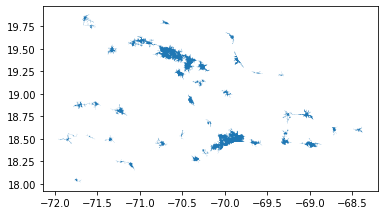

In [55]:
caipi_areas_merged_gdf = caipi_pre_concat_assign_transformer.transform(
    caipi_areas_gdf) 
shw(caipi_areas_merged_gdf)

In [56]:
gdf_caidminmujer_area.columns

Index(['cartodb_id', 'center', 'data_range', 'source_cartodb_id', 'name',
       'capacity', 'tipo', 'direccion', 'itm', 'municipality_key', 'geometry'],
      dtype='object')

### Ministerio de la Mujer - Neighboorhood

,Municipio_left,municipality_key,geometry,name,capacity,tipo,direccion,itm,index_right,Municipio_right,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,norm_municipio,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,Azua,0201,POINT (-70.74774 18.45327),Oficina de la Mujer Azua,NaN,Oficina de la Mujer,NaN,0,0,Azua,Dominican Republic,República Dominicana,DO,Región Valdesia,Region Valdesia,DO09,Provincia Azua,Provincia Azua,DO0901,Municipio Azua,Municipio Azua,DO090101,Azua,2,Azua,Azua de Compostela,azua,2.0,02,01,01,01,003,La Bombita,05,1,0502010101003,05020101101003,02010101003,NaN
1,Barahona,0401,POINT (-71.09750 18.20913),Oficina de la Mujer Barahona,NaN,Oficina de la Mujer,NaN,1,1,Barahona,Dominican Republic,República Dominicana,DO,Región Enriquillo,Region Enriquillo,DO06,Provincia Barahona,Provincia Barahona,DO0602,Municipio Barahona,Municipio Barahona,DO060201,Barahona,4,Barahona,Santa Cruz de Barahona,barahona,3.0,04,01,01,01,022,Centro De La Ciudad,06,1,0604010101022,06040101101022,04010101022,NaN


(46, 40)

<AxesSubplot:>

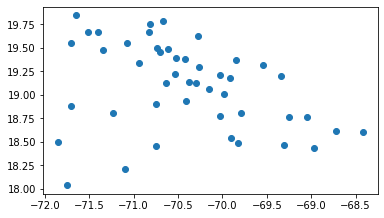

In [57]:
nonrepeated_cols = non_repeated_columns(gdf_caidminmujer_area, min_mujer_neigh_gdf, [],  ['index_right', 'left_index'],True)
minmujer_areas_neigh_gdf = gpd.sjoin(min_mujer_to_merge_gdf, min_mujer_neigh_gdf[nonrepeated_cols])
shw(minmujer_areas_neigh_gdf)

### CAIPI - Neighborhoods

(156, 19)
(157, 52)


,cartodb_id,center,data_range,source_cartodb_id,region,provincia,municipio,numcentro,centro,tipo,direccion,latitud,longitud,geometry,influence_area,influence_area_name,norm_municipio,municipality_key,capacity,norm_municipio_left,index_right,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,Municipio,norm_municipio_right,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,1,0101000020E61000006A1327F73B7651C01F9DBAF2595E...,600,9,NORTE ORIENTAL,MARiA TRINIDAD SaNCHEZ,NAGUA,9,SAN JOSE DE VILLA,CAIPI,M. T. SaNCHEZ / NAGUA,19.36856,-69.84741,"MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ...",9,SAN JOSE DE VILLA,nagua,1401,334,nagua,1195,Dominican Republic,República Dominicana,DO,Región Cibao Nordeste,Region Cibao Nordeste,DO01,Provincia María Trinidad Sánchez,Provincia Maria Trinidad Sanchez,DO0103,Municipio Nagua,Municipio Nagua,DO010301,María Trinidad Sánchez,14,Nagua,Nagua,Nagua,nagua,4.0,14,01,01,01,006,San José De Villa (Cumajon),03,1,0314010101006,03140101101006,14010101006,1.0
1,2,0101000020E6100000F37684D3822D51C00F289B728597...,600,1,ESTE,LA ALTAGRACIA,HIGuEY,1,LA MALENA,CAIPI,"CALLE LEO TAVAREZ, ESQUINA CALLE FIDEL RIJO, M...",18.59188,-68.71111,"MULTIPOLYGON (((-68.73399 18.58286, -68.73373 ...",1,LA MALENA,higuey,1101,290,higuey,11967,Dominican Republic,República Dominicana,DO,Región Yuma,Region Yuma,DO10,Provincia La Altagracia,Provincia La Altagracia,DO1002,Municipio Higüey,Municipio Higuey,DO100201,La Altagracia,11,Higüey,Salvaleón de Higüey,Higüey,higuey,4.0,11,01,01,01,032,La Malena,08,1,0811010101032,08110101101032,11010101032,1.0


(157, 52)

<AxesSubplot:>

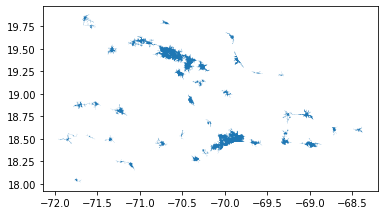

In [58]:
nonrepeated_cols = non_repeated_columns(caipi_areas_merged_gdf, caipi_barrios_gdf, ['latitud', 'longitud'], [], False)
print(caipi_areas_merged_gdf.shape)
caipi_areas_neigh_gdf = caipi_areas_merged_gdf.merge(caipi_barrios_gdf[nonrepeated_cols], on =[ 'latitud', 'longitud'])
print(caipi_areas_neigh_gdf.shape)

caipi_areas_neigh_gdf = caipi_pre_concat_assign_transformer.transform(
    caipi_areas_neigh_gdf) 
shw(caipi_areas_neigh_gdf)

### Other geolocated centers - Municipalities

,cartodb_id,center,data_range,source_cartodb_id,level_0,itm,_query,municipio,region,components,language,address,longitude,latitude,formatted_address,place_id,geometry_bounds_northeast_lat,geometry_bounds_northeast_lng,geometry_bounds_southwest_lat,geometry_bounds_southwest_lng,geometry_location_lat,geometry_location_lng,geometry_location_type,geometry_viewport_northeast_lat,geometry_viewport_northeast_lng,geometry_viewport_southwest_lat,geometry_viewport_southwest_lng,partial_match,plus_code_compound_code,plus_code_global_code,geometry,municipality_key,direccion,nombre,provincia,capacidad,has_epes,center_type
0,1,0101000020E6100000D9322ABABFD551C0EB4B80AB867A...,600,105,ASFL PERMANENTES ONGS,18,"C/Santiago Rodriguez No. 6, Provincia San Juan...",None,None,{'country': 'DO'},es,"Santiago Rodríguez, República Dominicana",-71.339827,19.478617,"Santiago Rodríguez, República Dominicana",ChIJnU2mu3UDsY4RtuOgExPlVwM,19.576825,-71.077057,19.216424,-71.5556,19.478617,-71.339827,APPROXIMATE,19.576825,-71.077057,19.216424,-71.555600,None,None,None,"MULTIPOLYGON (((-71.39173 19.43619, -71.39088 ...",2601,None,"Hogar de Ancianos San Juan, Inc",NaN,23.0,False,ASFL PERMANENTES ONGS
1,7,0101000020E61000006A6CAF053D7B51C03782F9D0AA95...,600,2,ASFL DIURNAS,2,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuproden...,None,None,{'country': 'DO'},es,"Higuero, Santo Domingo, República Dominicana",-69.925600,18.584638,"Higuero, Santo Domingo, República Dominicana",ChIJoVi91O2Or44RR__U2iw6TFY,NaN,NaN,NaN,NaN,18.584638,-69.925600,GEOMETRIC_CENTER,18.585987,-69.924251,18.583289,-69.926948,1,"H3MF+VQ Santo Domingo, República Dominicana",77CGH3MF+VQ,"MULTIPOLYGON (((-69.97939 18.59505, -69.97261 ...",3203,None,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuprodenty),NaN,36.0,False,ASFL DIURNAS


(472, 38)

<AxesSubplot:>

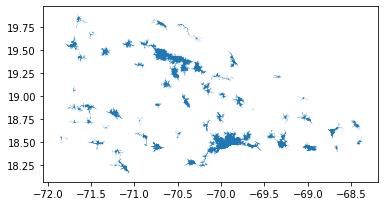

In [59]:
# merge conape capacities
other_areas_merged_gdf = other_located_areas.merge(
    gdf_othcercenters[['level_0', 'itm', 'capacidad', 'has_epes']]).pipe(
    other_centers_pre_concat_select_transformer.transform)
shw(other_areas_merged_gdf)

### Other geolocated centers - Neighborhoods

(470, 65)
(471, 82)


,cartodb_id,center,data_range,source_cartodb_id,level_0,itm,_query,municipio,region,components,language,address,longitude,latitude,formatted_address,place_id,geometry_bounds_northeast_lat,geometry_bounds_northeast_lng,geometry_bounds_southwest_lat,geometry_bounds_southwest_lng,geometry_location_lat,geometry_location_lng,geometry_location_type,geometry_viewport_northeast_lat,geometry_viewport_northeast_lng,geometry_viewport_southwest_lat,geometry_viewport_southwest_lng,partial_match,plus_code_compound_code,plus_code_global_code,geometry,municipality_key,direccion,nombre,provincia,capacidad,has_epes,center_type,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,plus_code.compound_code,plus_code.global_code,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM1_ES,ADM1_REF,ADM1_PCODE,ADM2_ES,ADM2_REF,ADM2_PCODE,ADM3_ES,ADM3_REF,ADM3_PCODE,Provincia,Código de provincia,Municipio cabecera,Ciudad capital,Municipio,norm_municipio,caipi_sum,PROV,MUN,DM,SECC,BP,TOPONIMIA,REG,ZONA,ENLACE,CODIGO,neighborhood_key,caipi_sum_neighbor
0,1,0101000020E6100000D9322ABABFD551C0EB4B80AB867A...,600,105,ASFL PERMANENTES ONGS,18,"C/Santiago Rodriguez No. 6, Provincia San Juan...",None,None,{'country': 'DO'},es,"Santiago Rodríguez, República Dominicana",-71.339827,19.478617,"Santiago Rodríguez, República Dominicana",ChIJnU2mu3UDsY4RtuOgExPlVwM,19.576825,-71.077057,19.216424,-71.5556,19.478617,-71.339827,APPROXIMATE,19.576825,-71.077057,19.216424,-71.555600,None,None,None,"MULTIPOLYGON (((-71.39173 19.43619, -71.39088 ...",2601,None,"Hogar de Ancianos San Juan, Inc",NaN,23.0,False,ASFL PERMANENTES ONGS,19.576825,-71.077057,19.216424,-71.5556,19.478617,-71.339827,APPROXIMATE,19.576825,-71.077057,19.216424,-71.555600,None,None,Dominican Republic,República Dominicana,DO,Región Cibao Noroeste,Region Cibao Noroeste,DO02,Provincia Santiago Rodríguez,Provincia Santiago Rodriguez,DO0203,Municipio San Ignacio de Sabaneta,Municipio San Ignacio de Sabaneta,DO020301,Santiago Rodríguez,26,San Ignacio de Sabaneta,San Ignacio de Sabaneta,San Ignacio de Sabaneta,san ignacio de sabaneta,1.0,26,01,01,01,011,Norte,04,1,0426010101011,04260101101011,26010101011,NaN
1,7,0101000020E61000006A6CAF053D7B51C03782F9D0AA95...,600,2,ASFL DIURNAS,2,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuproden...,None,None,{'country': 'DO'},es,"Higuero, Santo Domingo, República Dominicana",-69.925600,18.584638,"Higuero, Santo Domingo, República Dominicana",ChIJoVi91O2Or44RR__U2iw6TFY,NaN,NaN,NaN,NaN,18.584638,-69.925600,GEOMETRIC_CENTER,18.585987,-69.924251,18.583289,-69.926948,1,"H3MF+VQ Santo Domingo, República Dominicana",77CGH3MF+VQ,"MULTIPOLYGON (((-69.97939 18.59505, -69.97261 ...",3203,None,Fundacion Pro-Desarrollo Mi Tio Y Yo (fuprodenty),NaN,36.0,False,ASFL DIURNAS,NaN,NaN,NaN,NaN,18.584638,-69.925600,GEOMETRIC_CENTER,18.585987,-69.924251,18.583289,-69.926948,"H3MF+VQ Santo Domingo, República Dominicana",77CGH3MF+VQ,Dominican Republic,República Dominicana,DO,Región Ozama,Region Ozama,DO08,Provincia Santo Domingo,Provincia Santo Domingo,DO0802,Municipio Santo Domingo Norte,Municipio Santo Domingo Norte,DO080203,Santo Domingo,32,Santo Domingo Este,Santo Domingo Este,Santo Domingo Norte,santo domingo norte,11.0,32,03,01,01,006,San Felipe,10,1,1032030101006,10320301101006,32030101006,1.0


(471, 82)

<AxesSubplot:>

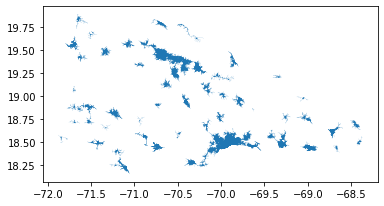

In [60]:
#TODO: variable nombr used as common key, a single key is required
nonrepeated_cols = non_repeated_columns(other_areas_merged_gdf, other_centers_neigh_gdf, ['nombre'], [],False)
print(other_centers_neigh_gdf.shape)
other_areas_neigh_gdf = other_areas_merged_gdf.merge(other_centers_neigh_gdf[nonrepeated_cols], on =['nombre'])
print(other_areas_neigh_gdf.shape)
shw(other_areas_neigh_gdf)

## Concatenate - Municipalities

In [61]:
caipi_areas_merged_gdf.columns

Index(['cartodb_id', 'center', 'data_range', 'source_cartodb_id', 'region',
       'provincia', 'municipio', 'numcentro', 'centro', 'tipo', 'direccion',
       'latitud', 'longitud', 'geometry', 'influence_area',
       'influence_area_name', 'norm_municipio', 'municipality_key',
       'capacity'],
      dtype='object')

,name,tipo,itm,capacidad,municipality_key,geometry
0,SAN JOSE DE VILLA,CAIPI,9,334,1401,"MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ..."
1,LA MALENA,CAIPI,1,290,1101,"MULTIPOLYGON (((-68.73399 18.58286, -68.73373 ..."


(677, 6)

<AxesSubplot:>

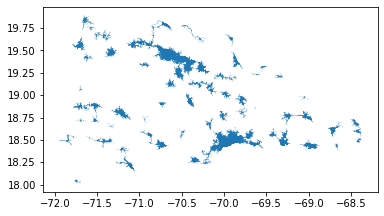

In [62]:
areas_concat_map = {
    # columns: caipi, caid & Min Mujer, others
    'name': ['centro', 'name', 'nombre'],
    'tipo': ['tipo', 'tipo', 'center_type'], 
    'itm': ['numcentro', 'itm', 'itm'],
    'capacidad': ['capacity', 'capacity', 'capacidad']
}
keep_features = ['municipality_key', 'geometry']

concat_caipi_areas = rename_to_concat(
    caipi_areas_merged_gdf, 0, concat_map=areas_concat_map, keep_features = keep_features)
concat_caid_min_mujer = rename_to_concat(
    gdf_caidminmujer_area, 1, concat_map=areas_concat_map, keep_features =keep_features)
concat_other_areas = rename_to_concat(
    other_areas_merged_gdf, 2, concat_map=areas_concat_map, keep_features =keep_features)

concat_areas = pd.concat((
concat_caipi_areas, concat_caid_min_mujer, concat_other_areas), ignore_index=True)
shw(concat_areas)

## Concatenate - Neighborhoods

,name,tipo,itm,capacidad,municipality_key,geometry,neighborhood_key
0,SAN JOSE DE VILLA,CAIPI,9,334.0,1401,"MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ...",14010101006
1,LA MALENA,CAIPI,1,290.0,1101,"MULTIPOLYGON (((-68.73399 18.58286, -68.73373 ...",11010101032


(674, 7)

<AxesSubplot:>

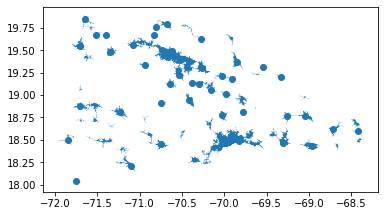

In [63]:

areas_concat_map = {
    # columns: caipi, caid & Min Mujer, others
    'name': ['centro', 'name', 'nombre'],
    'tipo': ['tipo', 'tipo', 'center_type'], 
    'itm': ['numcentro', 'itm', 'itm'],
    'capacidad': ['capacity', 'capacity', 'capacidad']
}
keep_features = ['municipality_key', 'geometry', 'neighborhood_key']

concat_caipi_areas = rename_to_concat(
    caipi_areas_neigh_gdf, 0, concat_map=areas_concat_map, keep_features = keep_features)
concat_caid_min_mujer = rename_to_concat(
    minmujer_areas_neigh_gdf, 1, concat_map=areas_concat_map, keep_features =keep_features)
concat_other_areas = rename_to_concat(
    other_areas_neigh_gdf, 2, concat_map=areas_concat_map, keep_features =keep_features)

concat_areas_neigh = pd.concat((
concat_caipi_areas, concat_caid_min_mujer, concat_other_areas), ignore_index=True)
shw(concat_areas_neigh)

#### Validation: concat_centers and concat_areas

In [64]:
concat_centers.tipo.value_counts().to_frame().reset_index()

,index,tipo
0,CAIPI,156
1,COS-Central,138
2,ASFL DIURNAS,87
3,CTC con EPES,72
4,COS-Norte,62
5,Oficina de la Mujer,46
6,CCPP SIN EPES,36
7,ASFL PERMANENTES ONGS,32
8,COS-Este,32
9,COS-Sur,26


## Export - Municipality

,poblacion_objetivo,leyenda,nombre,id,capacidad,tipo,municipio,geometry,municipality_key
0,primera infancia,Primera Infancia - CAIPI,San Jose De Villa,040009,334,Primera Infancia - CAIPI,"1401 - Nagua, María Trinidad Sánchez","MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ...",1401
122,primera infancia,Primera Infancia - CAIPI,Estancia Infantil Maria Trinidad Sanchez,041598,334,Primera Infancia - CAIPI,"1401 - Nagua, María Trinidad Sánchez","MULTIPOLYGON (((-69.89356 19.41559, -69.89296 ...",1401


(677, 9)

<AxesSubplot:>

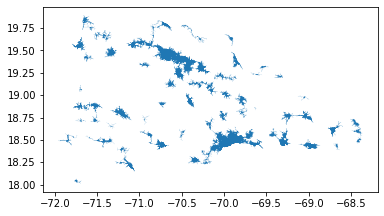

In [65]:

export_assign_map = {

    'id': lambda df: df['tipo'].map(center_types_dict).astype(str).str.zfill(
        2).str.cat(df.itm.astype(str).str.zfill(4)),
    'municipio': lambda df: df['municipality_key'].str.cat(
        df['Municipio'].str.cat(df['Provincia'], sep=', '),
        sep=' - '),
    'nombre': lambda df: name_normalizer(df['name']).str.title(),
    'leyenda': lambda df: df['tipo']
}

areas_export_assign_map = dict(filter(lambda t: t[0] in [
    'id', 'municipio', 'nombre', 'leyenda'], export_assign_map.items()))



areas_export_name_map = dict(filter(lambda t: not (t[0] in [
    'direccion']), export_name_map.items()))

export_areas_name_keep = ['leyenda', 'nombre', 'id', 'capacidad', 'tipo', 'municipio', 'geometry', 'municipality_key']

export_areas = concat_areas\
    .pipe(merge_municipalities.transform)\
    .pipe(SelectTransformer(export_select_map).transform)\
    .pipe(AssignTransformer(areas_export_assign_map).transform)\
    .pipe(ReplaceTransformer(export_replace_map, method='replace').transform)\
    .pipe(NameTransformer(areas_export_name_map, export_areas_name_keep).transform)
inspect_nulls(export_areas)
shw(export_areas)

In [66]:
concat_areas.columns

Index(['name', 'tipo', 'itm', 'capacidad', 'municipality_key', 'geometry'], dtype='object')

In [67]:
protected_save(
    lambda gdf, path: gdf.to_file(path, driver="GeoJSON"), export_areas, 
    f'{data_dir}/geo/parsed/car-influence-areas/care_car_areas-{timestamp}.'
    'geojson',
    ask_before_save=True
)

trying to save at: C:\Users\aleja\Dropbox\Github\criteria-dominicana\data/geo/parsed/car-influence-areas/care_car_areas-20211006T1542Z.geojson
not saved


## Export - Neighborhoods

In [68]:
merge_neighborhoods = MergeTransformer(lambda: neighborhood_gdf[[
    'municipality_key', 'neighborhood_key', 'Municipio', 'Provincia', 'TOPONIMIA']])

In [69]:
export_assign_map

{'id': <function __main__.<lambda>(df)>,
 'municipio': <function __main__.<lambda>(df)>,
 'nombre': <function __main__.<lambda>(df)>,
 'leyenda': <function __main__.<lambda>(df)>}

,poblacion_objetivo,leyenda,nombre,id,capacidad,tipo,municipio,geometry,barrio,municipality_key,neighborhood_key
0,primera infancia,Primera Infancia - CAIPI,San Jose De Villa,040009,334.0,Primera Infancia - CAIPI,"1401 - Nagua, María Trinidad Sánchez","MULTIPOLYGON (((-69.88558 19.32392, -69.88506 ...","14010101006 - San José De Villa (Cumajon), 140...",1401,14010101006
1,primera infancia,Primera Infancia - CAIPI,La Malena,040001,290.0,Primera Infancia - CAIPI,"1101 - Higüey, La Altagracia","MULTIPOLYGON (((-68.73399 18.58286, -68.73373 ...","11010101032 - La Malena, 1101 - Higüey, La Alt...",1101,11010101032


(668, 11)

<AxesSubplot:>

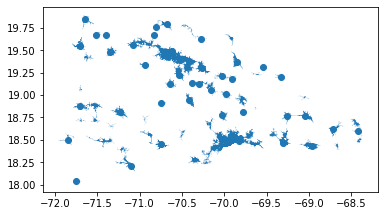

In [70]:

areas_export_name_map_neigh = dict(filter(lambda t: not (t[0] in [
    'direccion']), export_name_map.items()))

areas_export_assign_map_neigh= {

    'id': lambda df: df['tipo'].map(center_types_dict).astype(str).str.zfill(
        2).str.cat(df.itm.astype(str).str.zfill(4)),
    'municipio': lambda df: df['municipality_key'].str.cat(
        df['Municipio'].str.cat(df['Provincia'], sep=', '),
        
        sep=' - '),
    
    'barrio': lambda df: df['neighborhood_key'].str.cat(
            df['TOPONIMIA'].str.cat( 
                df['municipio'],
            sep=', '), 
        sep=' - '),

    'nombre': lambda df: name_normalizer(df['name']).str.title(),
    'leyenda': lambda df: df['tipo']
}

export_areas_name_keep_neigh = ['leyenda', 'nombre', 'id', 'capacidad', 'tipo', 'municipio', 'geometry', 'barrio', 'municipality_key', 'neighborhood_key']

export_areas_neigh = concat_areas_neigh\
    .pipe(merge_neighborhoods.transform)\
    .pipe(SelectTransformer(export_select_map_neigh).transform)\
    .pipe(AssignTransformer(areas_export_assign_map_neigh).transform)\
    .pipe(ReplaceTransformer(export_replace_map_neigh, method='replace').transform)\
    .pipe(NameTransformer(areas_export_name_map_neigh, export_areas_name_keep_neigh).transform)
inspect_nulls(export_areas_neigh)
shw(export_areas_neigh)

In [71]:
export_areas_neigh.barrio

0      14010101006 - San José De Villa (Cumajon), 140...
1      11010101032 - La Malena, 1101 - Higüey, La Alt...
577    11010101032 - La Malena, 1101 - Higüey, La Alt...
2      11010304027 - Las Dos Jardas, 1101 - Higüey, L...
3      25020101011 - 27 De Febrero, 2502 - Bisonó, Sa...
                             ...                        
659    17010601007 - Papatino (Villa Luz), 1701 - Ban...
660    04050101006 - Pueblo Arriba, 0405 - Vicente No...
662    02010101010 - La Colonia Española, 0201 - Azua...
664    02040101003 - Basilio Linia, 0204 - Padre Las ...
665      04010101007 - Savica, 0401 - Barahona, Barahona
Name: barrio, Length: 668, dtype: object

In [72]:
protected_save(
    lambda gdf, path: gdf.to_file(path, driver="GeoJSON"), export_areas_neigh, 
    f'{data_dir}/geo/parsed/car-influence-areas/care_car_areas_neigh-{timestamp}.'
    'geojson',
    ask_before_save=True
)

trying to save at: C:\Users\aleja\Dropbox\Github\criteria-dominicana\data/geo/parsed/car-influence-areas/care_car_areas_neigh-20211006T1542Z.geojson
not saved


In [73]:
 export_areas_neigh.to_csv(f'care_car_areas_neigh-{timestamp}.csv')

In [74]:
ctc_muni_src_gdf

,Municipio,municipality_key,geometry,nombre del ctc,provincia,municipio,capacidad fisica,tipo,direccion,itm
0,Castillo,0603,"POLYGON ((-70.05599 19.30336, -70.05177 19.303...",Castillo,DUARTE,Castillo,40,CTC con EPES,NaN,6
1,Villa Riva,0605,"POLYGON ((-69.92088 19.25847, -69.91969 19.258...",Villa riva,Duarte,Villa Riva,40,CTC con EPES,NaN,69
2,Salcedo,1901,"POLYGON ((-70.41161 19.55735, -70.41133 19.557...",Salcedo,HERMANAS MIRABAL,Salcedo,40,CTC con EPES,NaN,61
3,El Factor,1403,"POLYGON ((-69.88926 19.35513, -69.88855 19.355...",El Factor De Nagua,MARÍA Trinidad Sánchez,El Factor,40,CTC con EPES,NaN,13
4,El Pino,0505,"POLYGON ((-71.48121 19.49345, -71.48059 19.493...",Manuel Bueno,DAJABÓN,El Pino,40,CTC con EPES,NaN,39
...,...,...,...,...,...,...,...,...,...,...
67,Miches,0802,"MULTIPOLYGON (((-69.17101 19.01590, -69.17005 ...",El Cedro,EL SEIBO,Miches,40,CTC con EPES,NaN,11
68,Miches,0802,"MULTIPOLYGON (((-69.17101 19.01590, -69.17005 ...",Miches,EL SEIBO,Miches,40,CTC con EPES,NaN,42
69,Higüey,1101,"POLYGON ((-68.77574 18.97415, -68.77499 18.973...",Punta Cana,SAN JUAN DE LA MAGUANA,Higüey,40,CTC con EPES,NaN,53
70,Guaymate,1202,"POLYGON ((-68.95329 18.65861, -68.95236 18.658...",Guaymate,LA ROMANA,Guaymate,40,CTC con EPES,NaN,23


# Frontera
## Pre-concatenate Transforms

### CTC

In [75]:
ctc_muni_dissolved_gdf = ctc_muni_src_gdf.dissolve(
    'municipality_key', aggfunc={
    'nombre del ctc': lambda srs: ', '.join(srs),
    'municipio': 'count',
    'capacidad fisica': 'sum',
    # 'geometry': 'first'
}, as_index=False)

# for boundaries geojson
ctc_muni_boundaries_gdf = ctc_muni_dissolved_gdf.copy()
ctc_muni_boundaries_gdf['geometry'] = ctc_muni_boundaries_gdf[
    'geometry'].boundary.to_crs(crs="EPSG:4326")
ctc_muni_boundaries_gdf = ctc_muni_boundaries_gdf.assign(
    tipo='CTC con EPES')

### INFOTEP

In [76]:
infotep_geo_src_df = df_infotep.copy()
# infotep_geo_src_df = infotep_geo_src_df[lambda df: df.provincia.ne(
#     'Bavaro- Punta Cana')]
infotep_geo_src_df.provincia.nunique()

infotep_geo_src_df['Provincia'] = infotep_geo_src_df.provincia.map(
    lambda x: get_close_matches(
        x, gdf_municipalities.Provincia.values, n=1, cutoff=.4)[0])
infotep_geo_src_df.loc[lambda df: df.provincia.eq(
    'Santiago de los Caballeros'), 'Provincia'] = 'Santiago'
infotep_geo_src_df['infotep'] = infotep_geo_src_df[
    'direccion regional'].str.replace('Dirección Regional', 'DR').add(
    ', ').add(infotep_geo_src_df[
    'servicios formacion  profesional y oficina satelite']).str.replace(
    'Departamento de', 'Dept.').str.replace(
    'Servicios Formacion ', 'Serv. Form.')

# infotep_muni_df = infotep_geo_src_df.merge(gdf_municipalities[[
#     'Provincia', 'municipality_key']]).drop([
#     'direccion regional', 'provincia', 'Provincia',
#     'servicios formacion  profesional y oficina satelite'], axis=1)
# infotep_muni_df

infotep_gdf_provinces = gdf_provinces[['Provincia', 'geometry']].merge(
    infotep_geo_src_df).merge(gdf_othcercenters[['nombre', 'municipality_key']])
infotep_gdf_provinces = infotep_gdf_provinces.assign(tipo='INFOTEP')

In [77]:
infotep_gdf_provinces

,Provincia,geometry,direccion regional,servicios formacion profesional y oficina satelite,provincia,nombre,direccion,infotep,municipality_key,tipo
0,Duarte,"POLYGON ((-70.22724 19.51581, -70.22495 19.515...",Dirección Regional Norte,Oficina Satelite Nordeste ...,Duarte,Oficina Satelite Nordeste,Calle San Francisco esq. Papi Olivier y Billi...,"DR Norte, Oficina Satelite Nordeste ...",0601,INFOTEP
1,Hermanas Mirabal,"POLYGON ((-70.30365 19.55838, -70.30099 19.556...",Dirección Regional Norte,Oficina Satelite Nordeste ...,Hermanas Mirabal,Oficina Satelite Nordeste,Calle San Francisco esq. Papi Olivier y Billi...,"DR Norte, Oficina Satelite Nordeste ...",0601,INFOTEP
2,María Trinidad Sánchez,"POLYGON ((-69.98899 19.68047, -69.98877 19.680...",Dirección Regional Norte,Oficina Satelite Nordeste ...,María Trinidad Sánchez,Oficina Satelite Nordeste,Calle San Francisco esq. Papi Olivier y Billi...,"DR Norte, Oficina Satelite Nordeste ...",0601,INFOTEP
3,Samaná,"MULTIPOLYGON (((-69.60654 19.08105, -69.60590 ...",Dirección Regional Norte,Oficina Satelite Nordeste ...,Samaná,Oficina Satelite Nordeste,Calle San Francisco esq. Papi Olivier y Billi...,"DR Norte, Oficina Satelite Nordeste ...",0601,INFOTEP
4,Sánchez Ramírez,"POLYGON ((-70.26764 19.16303, -70.26660 19.163...",Dirección Regional Norte,Oficina Satelite Nordeste ...,Sánchez Ramirez,Oficina Satelite Nordeste,Calle San Francisco esq. Papi Olivier y Billi...,"DR Norte, Oficina Satelite Nordeste ...",0601,INFOTEP
5,Dajabón,"POLYGON ((-71.60179 19.62930, -71.60128 19.628...",Dirección Regional Norte,Departamento de Servicios Formacion Profesiona...,Dajabón,Dirección Regional Norte,"Av. Estrela Sadhalá Esq. Hatuey, sector Cambo...","DR Norte, Dept. Serv. Form.Profesional ...",2501,INFOTEP
6,Monte Cristi,"MULTIPOLYGON (((-71.75497 19.82121, -71.75580 ...",Dirección Regional Norte,Departamento de Servicios Formacion Profesiona...,Monte Cristi,Dirección Regional Norte,"Av. Estrela Sadhalá Esq. Hatuey, sector Cambo...","DR Norte, Dept. Serv. Form.Profesional ...",2501,INFOTEP
7,Santiago Rodríguez,"POLYGON ((-71.30987 19.55965, -71.30867 19.559...",Dirección Regional Norte,Departamento de Servicios Formacion Profesiona...,Santiago Rodríguez,Dirección Regional Norte,"Av. Estrela Sadhalá Esq. Hatuey, sector Cambo...","DR Norte, Dept. Serv. Form.Profesional ...",2501,INFOTEP
8,Valverde,"POLYGON ((-71.13874 19.75691, -71.13588 19.755...",Dirección Regional Norte,Departamento de Servicios Formacion Profesiona...,Valverde,Dirección Regional Norte,"Av. Estrela Sadhalá Esq. Hatuey, sector Cambo...","DR Norte, Dept. Serv. Form.Profesional ...",2501,INFOTEP
9,Espaillat,"POLYGON ((-70.36341 19.70078, -70.36199 19.699...",Dirección Regional Norte,Departamento de Servicios Formacion Profesiona...,Espaillat,Dirección Regional Norte,"Av. Estrela Sadhalá Esq. Hatuey, sector Cambo...","DR Norte, Dept. Serv. Form.Profesional ...",2501,INFOTEP


In [78]:
infotep_buffer = 1e-4
infotep_regions_gdf = infotep_gdf_provinces.copy()
infotep_regions_gdf.loc[:, 'geometry'] = infotep_regions_gdf[
    'geometry'].buffer(infotep_buffer).to_crs(crs="EPSG:4326")
infotep_regions_gdf = infotep_regions_gdf.dissolve('nombre')


# solve inconsistence from Oficina Satelite de Higuey which covers a 
# municipality (Higuey) instead of a province
infotep_regions_gdf.loc['Dirección Regional Este', 'geometry'] = \
    gpd.GeoSeries(gdf_municipalities.loc[
        lambda df: name_normalizer(df.Provincia).isin(name_normalizer(
            infotep_gdf_provinces.loc[
            lambda df: df['nombre'].eq('Dirección Regional Este'), 'provincia'])), 
        'geometry'].unary_union.difference(
            gdf_municipalities.loc[
                lambda df: df['municipality_key'].eq('1101'), 'geometry'].iloc[0]
        ).buffer(infotep_buffer), crs="EPSG:4326").values

infotep_regions_gdf.loc['Oficina Satelite de Higuey', 'geometry'] = \
    gdf_municipalities.loc[
        lambda df: df['municipality_key'].eq('1101'), 'geometry'].values

C:\Users\aleja\anaconda3\envs\criteria-do\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [79]:
infotep_boundary_gdf = infotep_regions_gdf.copy()
infotep_boundary_gdf['geometry'] = infotep_boundary_gdf[
    'geometry'].boundary.to_crs(crs="EPSG:4326")

### PROSOLI

In [80]:
prosoli_buffer = 1e-4
prosoli_merged_df = df_prosoli.assign(nombre=lambda df: 'DR. ' + df[
    'match'].str.replace(r'Director(a)? Regional', '', regex=True).str.strip(
    '\xa0').str.strip()).merge(gdf_othcercenters[['level_0', 'itm', 'nombre']])

normalized_province_col = 'norm_provincia'
prosoli_merged_df = prosoli_merged_df.assign(**{
    normalized_province_col: name_normalizer(
        prosoli_merged_df.parsed_provincia).map(
        lambda x: get_close_matches(
            x, name_normalizer(gdf_municipalities.Provincia).values, n=1,
            cutoff=.4)[0])
})
prosoli_merged_gdf = gdf_provinces.assign(**{
    normalized_province_col: name_normalizer(gdf_provinces.Provincia)
})[[normalized_province_col, 'geometry']].merge(
    prosoli_merged_df, on=normalized_province_col).merge(
    gdf_othcercenters[['nombre', 'municipality_key']])

In [81]:
# build administrative regions gdf
prosoli_regions_gdf = prosoli_merged_gdf.copy()
prosoli_regions_gdf.loc[:, 'geometry'] = prosoli_regions_gdf[
    'geometry'].buffer(prosoli_buffer).to_crs(crs="EPSG:4326")
prosoli_regions_gdf.loc[:, 'nombre'] = prosoli_regions_gdf.loc[
    :, 'nombre'].replace(
    'DR. Santo Domingo Oetse', 'DR. Santo Domingo Oeste')
prosoli_regions_gdf = prosoli_regions_gdf.dissolve('nombre')

# disagregate regions not only bounded by province limits
disagregate_provinces_prosoli_dict = {
        'DR. Santo Domingo Este': ['3201', '3205', '3204'],
        'DR. Santo Domingo Norte': ['3203', *[f'290{i}' for i in range(1, 6)]],
        'DR. Santo Domingo Oeste': ['3202', '3207', '3206'],
    }
disagregate_provinces_prosoli_gdf = gdf_municipalities.pipe(SelectTransformer({
    'nombre': {
        **{lambda df, muni_keys=val: df.municipality_key.isin(muni_keys): key
              for key, val in disagregate_provinces_prosoli_dict.items()},
        'default': None
    }
}).transform).dropna(subset=['nombre'])

disagregate_provinces_prosoli_gdf.loc[:, 'geometry'] = \
    disagregate_provinces_prosoli_gdf.geometry.buffer(prosoli_buffer).to_crs(
    crs="EPSG:4326")
disagregate_provinces_prosoli_gdf = disagregate_provinces_prosoli_gdf.dissolve(
    'nombre')

prosoli_regions_gdf.loc[
    disagregate_provinces_prosoli_gdf.index, 'geometry'
    ] = disagregate_provinces_prosoli_gdf.geometry

prosoli_regions_gdf = prosoli_regions_gdf.assign(tipo='prosoli')

C:\Users\aleja\anaconda3\envs\criteria-do\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
C:\Users\aleja\anaconda3\envs\criteria-do\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [82]:
prosoli_boundary_gdf = prosoli_regions_gdf.copy()
prosoli_boundary_gdf['geometry'] = prosoli_boundary_gdf[
    'geometry'].boundary.to_crs(crs="EPSG:4326")

## Concatenate

In [83]:

boundaries_concat_map = {
    # columns correspond to: ctc, infotep and prosoli
    'name': ['nombre del ctc', 'nombre', 'nombre'],
    'tipo': ['tipo', 'tipo', 'tipo'], 
    # 'itm': ['numcentro', 'itm']
}

boundaries_concat_map = {
    # columns correspond to: ctc, infotep and prosoli
    'name': ['nombre del ctc', 'nombre', 'nombre'],
    'tipo': ['tipo', 'tipo', 'tipo'], 
    # 'itm': ['numcentro', 'itm']
}
keep_features = ['municipality_key', 'geometry']

def rename_to_concat(df, i, concat_map=concat_map, keep_features=keep_features):
    return NameTransformer({
        v[i]: k for k, v in concat_map.items()}, keep_features=keep_features
    ).transform(df) 


concat_ctc_boundaries = rename_to_concat(
    ctc_muni_boundaries_gdf, 0, concat_map=boundaries_concat_map, keep_features=keep_features )
concat_infotep_boundaries = rename_to_concat(
    infotep_boundary_gdf.reset_index(), 1, concat_map=boundaries_concat_map, keep_features=keep_features)
concat_prosoli_boundaries = rename_to_concat(
    prosoli_boundary_gdf.reset_index(), 2, concat_map=boundaries_concat_map, keep_features=keep_features)

concat_boundaries = pd.concat((
    concat_ctc_boundaries, concat_infotep_boundaries, 
    concat_prosoli_boundaries), ignore_index=True)
concat_boundaries

,name,tipo,municipality_key,geometry
0,"Las Yayas, Villarpando",CTC con EPES,0203,"MULTILINESTRING ((-70.88859 18.53131, -70.8890..."
1,Padre las casas,CTC con EPES,0204,"LINESTRING (-70.86264 19.00132, -70.86151 19.0..."
2,Peralta,CTC con EPES,0205,"LINESTRING (-70.82254 18.66421, -70.82158 18.6..."
3,Sabana Yegua,CTC con EPES,0206,"LINESTRING (-70.85519 18.45851, -70.84996 18.4..."
4,Pueblo viejo,CTC con EPES,0207,"LINESTRING (-70.75679 18.44825, -70.75715 18.4..."
...,...,...,...,...
77,DR. Noroeste,prosoli,2701,"MULTILINESTRING ((-71.79424 19.83050, -71.7942..."
78,DR. Santo Domingo Este,prosoli,0101,"MULTILINESTRING ((-69.61404 18.44294, -69.6140..."
79,DR. Santo Domingo Norte,prosoli,3203,"LINESTRING (-69.78633 18.57444, -69.78633 18.5..."
80,DR. Santo Domingo Oeste,prosoli,3202,"LINESTRING (-69.99875 18.50281, -69.99044 18.4..."


In [84]:
export_select_map

{'objective_pop': {<function __main__.<lambda>(df)>: 'adulto mayor dependiente',
  <function __main__.<lambda>(df)>: 'centro de formacion',
  <function __main__.<lambda>(df)>: 'direccion regional',
  <function __main__.<lambda>(df)>: 'primera infancia',
  <function __main__.<lambda>(df)>: 'situacion de discapacidad',
  'default': nan}}

## Export Transforms

,poblacion_objetivo,nombre,tipo,municipio,geometry,municipality_key
0,primera infancia,"Las Yayas, Villarpando",Primera Infancia - CTC CON EPES,"0203 - Las Yayas de Viajama, Azua","MULTILINESTRING ((-70.88859 18.53131, -70.8890...",0203
1,primera infancia,Padre Las Casas,Primera Infancia - CTC CON EPES,"0204 - Padre Las Casas, Azua","LINESTRING (-70.86264 19.00132, -70.86151 19.0...",0204


(82, 6)

<AxesSubplot:>

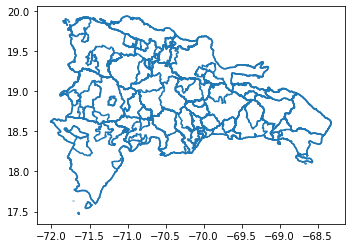

In [85]:
boundaries_export_assign_map = dict(filter(lambda t: t[0] in [
    'municipio', 'nombre'], export_assign_map.items()))

boundaries_export_name_map = dict(filter(lambda t: not (t[0] in [
    'capacidad', 'direccion', 'id', 'leyenda']), export_name_map.items()))
export_boundaries_name_keep = [
    x for x in export_areas_name_keep if not x in (
        'capacidad', 'id', 'leyenda', 'barrio')]


export_boundaries = concat_boundaries.pipe(
    merge_municipalities.transform).pipe(
    SelectTransformer(export_select_map).transform
).pipe(AssignTransformer(boundaries_export_assign_map).transform).pipe(
    ReplaceTransformer(export_replace_map, method='replace').transform).pipe(
    NameTransformer(
        boundaries_export_name_map, export_boundaries_name_keep).transform)
inspect_nulls(export_boundaries)
shw(export_boundaries)

In [86]:
if not runall:

    protected_save(
        lambda gdf, path: gdf.to_fiele(path, driver="GeoJSON"),
        export_boundaries, 
        f'{data_dir}/geo/parsed/administrative-boundaries/care-boundaries-'
        f'{timestamp}.geojson',
        ask_before_save=True
    )